## 书 An Introduction to Economic Dynamics
使用julia语言（版本1.9.3）改写里面matlab代码的经济模型

### Chapter2 蛛网模型
蛛网模型主要应用在农产品上

需求是瞬时的，提供什么马上就有对应的需求；而供给却是需要一年的播种耕种，所以供给会有滞后

- 需求方程$ D_t = d_0 + d_1  p_t $。 其中$d_0 \geq 0$，$d_1 < 0$
- 供给方程$ S_t = s_0 + s_1  p_{t-1} $。其中$s_0 \geq 0$，$s_1 >0 $

市场出清条件是$D_t = S_t$，也就是$ d_0 + d_1  p_t = s_0 + s_1  p_{t-1}$。整理后得到均衡价格的运动方程$$  p_t = \dfrac{s_1}{d_1} p_{t-1} + \dfrac{s_0 - d_0}{d_1} $$

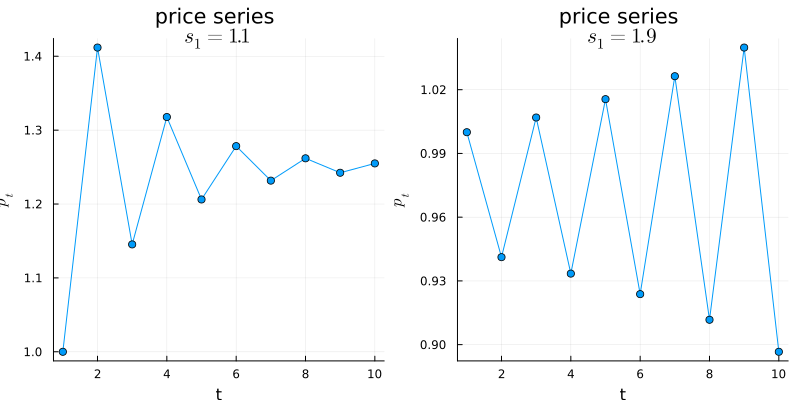

In [1]:
using Parameters, Plots, LaTeXStrings

paras = @with_kw (d_0 = 4.0, d_1 = -1.7, s_0 = 0.5, s_1 = 1.1, p_0 = 1.0 )

function cobweb(paras; iters = 10)
    d_0, d_1, s_0, s_1, p_0 = paras
    prices = zeros(iters); prices[1] = p_0
    for i in 2:iters
        prices[i] = s_1/d_1 * prices[i-1] + (s_0 - d_0)/ d_1
    end
    return prices
end

t = 10
prices1 = cobweb(paras(), iters=t)
prices2 = cobweb(paras(s_1=1.9), iters=t)
p1 = plot(1:t, prices1, title="price series \n" * L"s_1 = 1.1", legend = false, marker=4, xlabel="t", ylabel=L"p_t")
p2 = plot(1:t, prices2, title="price series \n" * L"s_1 = 1.9", legend = false, marker=4, xlabel="t", ylabel=L"p_t")
plot(p1, p2, layout=(1,2), size=(800,400))

价格在左图以震荡的方式收敛，但在右图却以震荡的方式发散，这是为什么？

如果有稳态的最终价格$p^*=p_t=p_{t-1}$存在，那么根据出清条件，有$ d_0 + d_1  p^* = s_0 + s_1 p^* $，可以解出$$ p^* = \dfrac{s_0 - d_0}{d_1 - s_1} $$

分母不为0，要求$d_1 \neq s_1$

再考虑各个时期到稳态的距离，如$p_t - p^*$和$p_{t-1} - p^*$。不难发现
$$ \textcolor{red}{p_t - p^*} = \dfrac{s_1}{d_1} p_{t-1} + \dfrac{s_0 - d_0}{d_1} -p^* = \dfrac{s_1}{d_1} (p_{t-1} -p^*)+ \dfrac{s_0 - d_0}{d_1} -p^* + \dfrac{s_1}{d_1} p^* = \textcolor{red}{ \dfrac{s_1}{d_1} (p_{t-1} -p^*) } $$

- 如果系数$\left| \dfrac{s_1}{d_1} \right| < 1$，那么到均衡价格的距离不断变小，价格会收敛
- 如果系数$\left| \dfrac{s_1}{d_1} \right| > 1$，那么到均衡价格的距离不断变大，价格会发散

考虑价格运动的方式是震荡还是单调，仅需考察系数$\dfrac{s_1}{d_1} $的正负号

- 如果系数$ \dfrac{s_1}{d_1} < 0 $，那么正负交替的震荡
- 如果系数$ \dfrac{s_1}{d_1} > 0 $，那么单调为正或者单调为负的前进

| 条件 | $  \left\vert \dfrac{s_1}{d_1} \right\vert  <  1 $ | $ \left\vert \dfrac{s_1}{d_1}  \right\vert >  1 $ |
| :-----:| :----: | :----: |
| $\dfrac{s_1}{d_1} < 0$ | 震荡收敛 | 震荡发散 |
| $\dfrac{s_1}{d_1} > 0$ | 单调收敛 | 单调发散 |

接下来画价格-数量图

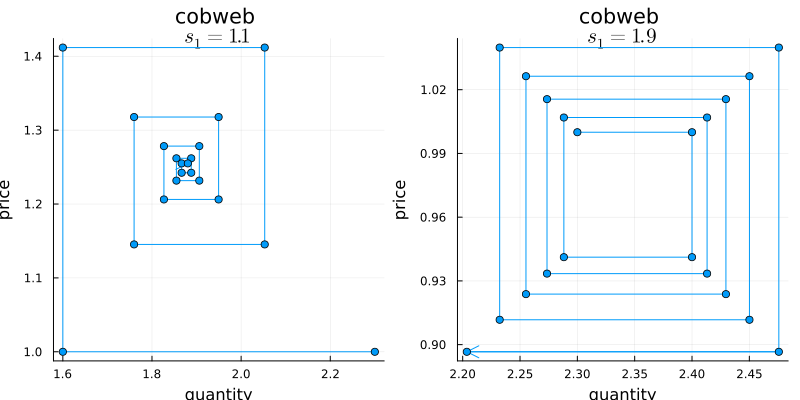

In [2]:
d_0, d_1, s_0, s_1, p_0 = paras()

Demand1 = d_0 .+ d_1 .* prices1; Supply1 = s_0 .+ s_1 .* prices1
s_1 = 1.9
Demand2 = d_0 .+ d_1 .* prices2; Supply2 = s_0 .+ s_1 .* prices2

ploty1 = zeros(2*t)
ploty2 = zeros(2*t)
plotx1 = zeros(2*t)
plotx2 = zeros(2*t)
for i in 1:(2*t)
    tmp = convert(Int, ifelse(i % 2 == 0, i/2, (i+1)/2 ) )
    ploty1[i] = prices1[tmp]
    ploty2[i] = prices2[tmp]
    plotx1[i] = ifelse( i % 2 == 0, Supply1[tmp], Demand1[tmp] )
    plotx2[i] = ifelse( i % 2 == 0, Supply2[tmp], Demand2[tmp] )
end

p3 = plot(plotx1, ploty1, title="cobweb \n" * L"s_1 = 1.1", legend = false, marker=4, xlabel="quantity", ylabel="price", arrow=true)
p4 = plot(plotx2, ploty2, title="cobweb \n" * L"s_1 = 1.9", legend = false, marker=4, xlabel="quantity", ylabel="price", arrow=true)
plot(p3, p4, layout=(1,2), size=(800,400))

### Chapter3 引入对未来预期的蛛网模型
第二章的蛛网模型，基于上期的价格$p_{t-1}$，农民进行播种耕种供给$S_t = s_0 + s_1  p_{t-1} $。实际为简单预期（naive expectation）$p_t^e = p_{t-1}$

本章扩展将其一般化，预期不再简单预期，那么有

- 需求方程$ D_t = d_0 + d_1  p_t $。 其中$d_0 \geq 0$，$d_1 < 0$
- 供给方程$ S_t = s_0 + s_1  p_t^e $。其中$s_0 \geq 0$，$s_1 >0 $

农民心中有个长期价格$p_N$。当下的预期为 $p_t^e = p_{t-1} + c(p_N - p_{t-1})$ 。其中$0<c<1$，表示调整速度。

- $c=0$时，变成简单预期
- $c=1$时，预期价格变成长期价格

$p_N$和$c$的设定较为主观。为了简单操作，本章设定$p_N = \dfrac{s_0 - d_0}{d_1 - s_1} $。

同样，根据市场出清条件$D_t = S_t$，求解得到价格的运动方程 $$ p_t = \dfrac{s_1}{d_1}(1-c)p_{t-1} + \dfrac{s_0 - d_0 + s_1 c p_N}{d_1} $$

不难发现，当各个参数都被设定后，编程方面与第二章也没有本质差异。

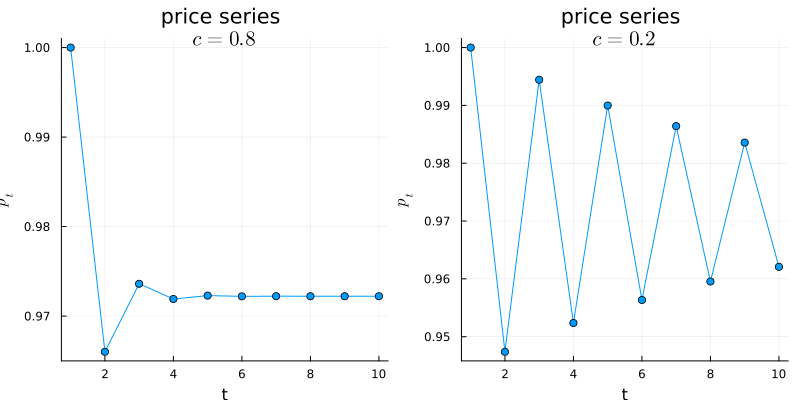

In [3]:
using Parameters, Plots, LaTeXStrings

paras = @with_kw (d_0 = 4.0, d_1 = -1.7, s_0 = 0.5, s_1 = 1.9, p_0 = 1.0, c = 0.8 )

function cobweb(paras; iters = 10)
    d_0, d_1, s_0, s_1, p_0, c = paras
    p_N = (s_0 - d_0) / (d_1 - s_1)
    prices = zeros(iters); prices[1] = p_0
    for i in 2:iters
        prices[i] = s_1/d_1 *(1-c)* prices[i-1] + (s_0 - d_0 + s_1 * c * p_N)/ d_1
    end
    return prices
end

t = 10
prices1 = cobweb(paras(), iters=t)
prices2 = cobweb(paras(c=0.2), iters=t)
p1 = plot(1:t, prices1, title="price series \n" * L"c = 0.8", legend = false, marker=4, xlabel="t", ylabel=L"p_t")
p2 = plot(1:t, prices2, title="price series \n" * L"c = 0.2", legend = false, marker=4, xlabel="t", ylabel=L"p_t")
plot(p1, p2, layout=(1,2), size=(800,400))

如果存在稳态价格$p^* = p_t = p_{t-1}$，也即 $ p^* = \dfrac{s_1}{d_1}(1-c)p^* + \dfrac{s_0 - d_0 + s_1 c p_N}{d_1} $。可以求得
$$ p^* = \dfrac{s_0 - d_0 + s_1 c p_N}{d_1 - s_1 (1-c)} \xlongequal{将 p_N 代入} \dfrac{s_0 - d_0}{d_1 - s_1} $$

无论$c$被设置成多少，由于$p_N$的设定，$p^*$都与第二章保持一致。

再考虑各个时期到稳态的距离，如$p_t - p^*$和$p_{t-1} - p^*$。不难发现
$$ \textcolor{red}{p_t - p^*} = \dfrac{s_1}{d_1}(1-c)p_{t-1} + \dfrac{s_0 - d_0 + s_1 c p_N}{d_1} -p^* = \dfrac{s_1(1-c)}{d_1} (p_{t-1} -p^*)+ \dfrac{s_0 - d_0+s_1 c p_N}{d_1} -p^* + \dfrac{s_1(1-c)}{d_1} p^* = \textcolor{red}{ \dfrac{s_1(1-c)}{d_1} (p_{t-1} -p^*) } $$

- 如果系数$\left| \dfrac{s_1(1-c)}{d_1} \right| < 1$，那么到均衡价格的距离不断变小，价格会收敛
- 如果系数$\left| \dfrac{s_1(1-c)}{d_1} \right| > 1$，那么到均衡价格的距离不断变大，价格会发散

考虑价格运动的方式是震荡还是单调，由于$1-c >0$，所以仅需考察系数$\dfrac{s_1}{d_1} $的正负号

- 如果系数$ \dfrac{s_1}{d_1} < 0 $，那么正负交替的震荡
- 如果系数$ \dfrac{s_1}{d_1} > 0 $，那么单调为正或者单调为负的前进

| 条件 | $  \left\vert \dfrac{s_1(1-c)}{d_1} \right\vert  <  1 $ | $ \left\vert \dfrac{s_1(1-c)}{d_1}  \right\vert >  1 $ |
| :-----:| :----: | :----: |
| $\dfrac{s_1}{d_1} < 0$ | 震荡收敛 | 震荡发散 |
| $\dfrac{s_1}{d_1} > 0$ | 单调收敛 | 单调发散 |

接下来画价格-数量图

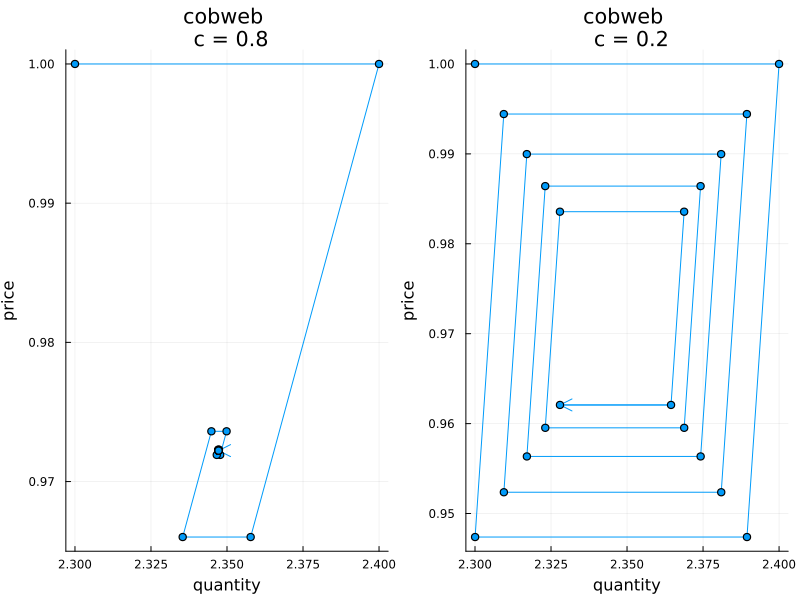

In [4]:
d_0, d_1, s_0, s_1, p_0 = paras()

Demand1 = d_0 .+ d_1 .* prices1; Supply1 = s_0 .+ s_1 .* prices1
c = 0.2
Demand2 = d_0 .+ d_1 .* prices2; Supply2 = s_0 .+ s_1 .* prices2

ploty1 = zeros(2*t)
ploty2 = zeros(2*t)
plotx1 = zeros(2*t)
plotx2 = zeros(2*t)
for i in 1:(2*t)
    tmp = convert(Int, ifelse(i % 2 == 0, i/2, (i+1)/2 ) )
    ploty1[i] = prices1[tmp]
    ploty2[i] = prices2[tmp]
    plotx1[i] = ifelse( i % 2 == 0, Supply1[tmp], Demand1[tmp] )
    plotx2[i] = ifelse( i % 2 == 0, Supply2[tmp], Demand2[tmp] )
end

p3 = plot(plotx1, ploty1, title="cobweb \n c = 0.8", legend = false, marker=4, xlabel="quantity", ylabel="price", arrow=true)
p4 = plot(plotx2, ploty2, title="cobweb \n c = 0.2", legend = false, marker=4, xlabel="quantity", ylabel="price", arrow=true)
plot(p3, p4, layout=(1,2), size=(800,600))

比较有名的适应性预期（*adaptive expectation*）规则，记为 $  p_t^e = p_{t-1}^e + \beta (p_{t-1} - p_{t-1}^e)  $。其中$0< \beta <1$被称为适应参数（*adaptation* parameter）。

### Chapter4 凯恩斯乘数模型

- 支出法核算GDP， $ Y = C+I+G+(X-M)$
- 增加值法核算GDP，$ Y = $ value of output sold $-$ cost of raw materials
- 收入法核算GDP，$Y = W + \Pi$，其中$W$表示劳动工资，$\Pi$表示资本的利润（租金收入）
  
考虑封闭经济体，总需求即是总支出 $Y^d = C+I+G $。总收入是$Y$。由于封闭内循环$Y^d = Y$。

线性消费函数$C = a+bY$，其中$0<b<1$表示边际消费倾向。

联合两个等式，有 $ Y = a + bY + I+G  \Rightarrow Y = \dfrac{1}{1-b} (a+I+G)$。这里的 $\dfrac{1}{1-b}$即是乘数。

引入离散时间，几个等式如下

- $ Y_t = C_t + I_t + G_t $
- $ C_t = a + b Y_{t-1} $
- $ I_t = \bar{I} $
- $ G_t = \bar{G} $

$Y$ 的运动方程为$$  Y_t = bY_{t-1} + a + \bar{I} + \bar{G}  $$

稳态时$Y^*= Y_t=Y_{t-1}$，那么有 $ Y^* = \dfrac{1}{1-b} (a+\bar{I}+\bar{G}) $

考察到稳态$Y^*$的距离，有 $ \textcolor{red}{Y_t - Y^*} = bY_{t-1} + a + \bar{I} + \bar{G} - Y^* = b(Y_{t-1} - Y^*) + a + \bar{I} + \bar{G} - Y^* + b Y^* = \textcolor{red}{b (Y_{t-1} - Y^*)} $

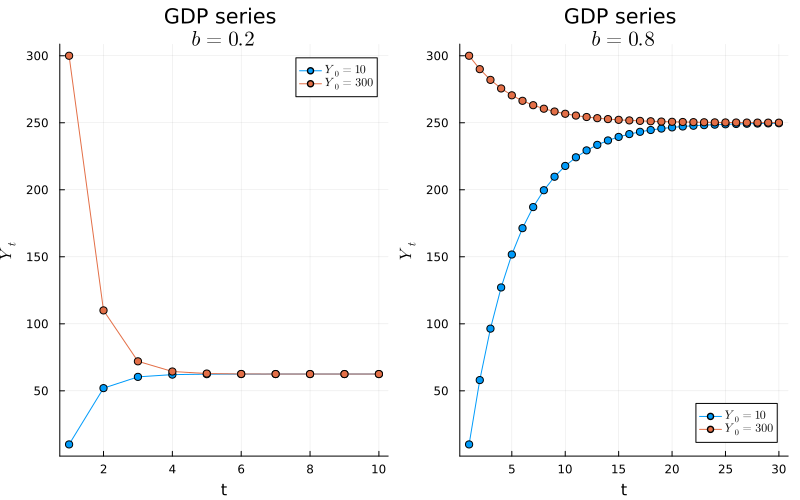

In [5]:
using Parameters, Plots, LaTeXStrings

paras = @with_kw (a = 10.0, Ibar = 20.0, Gbar = 20.0, b = 0.2, Y_0 = 10 )

function GDP(paras; iters = 10)
    a, Ibar, Gbar, b, Y_0 = paras
    Yseries = zeros(iters); Yseries[1] = Y_0
    for i in 2:iters
        Yseries[i] = b * Yseries[i-1] + a + Ibar + Gbar 
    end
    return Yseries
end

t1 = 10
t2 = 30
Yseries1 = GDP(paras(), iters=t1)
Yseries2 = GDP(paras(Y_0 = 300.0), iters=t1)
Yseries3 = GDP(paras(b=0.8), iters=t2)
Yseries4 = GDP(paras(b=0.8, Y_0 = 300.0), iters=t2)
p1 = plot(1:t1, [Yseries1  Yseries2], title="GDP series \n" * L"b = 0.2", label=[L"Y_0=10"  L"Y_0=300"], marker=4, xlabel="t", ylabel=L"Y_t")
p2 = plot(1:t2, [Yseries3  Yseries4], title="GDP series \n" * L"b = 0.8", label=[L"Y_0=10"  L"Y_0=300"], marker=4, xlabel="t", ylabel=L"Y_t")
plot(p1, p2, layout=(1,2),size=(800,500))

### Chapter5 IS-LM 模型
实物商品市场上，投资等于储蓄 $ I(Y,r) = S(Y,r) $，其中$Y$是收入，$r$是利率。具体而言
- 储蓄等于收入减去消费$S = Y- C=(1-a_1)Y$，其中$0<a_1 <1$
- 投资$I = \bar{I} - a_2 r$，其中 $a_2 >0$

货币市场上，货币供给外生 $\bar{M} = \dfrac{M}{P} $。货币的流动性需求 $ L(Y,r) = k_1 Y - k_2 r$

各个函数的变化方向（偏导数）有

- $ 0< \frac{\partial I}{\partial Y} <1 $，可以视为边际投资倾向
- $ \frac{\partial I}{\partial r} < 0 $，利率越高越不愿意投资
- $ 0< \frac{\partial S}{\partial Y} <1 $，边际储蓄倾向
- $ \frac{\partial S}{\partial r} > 0 $，利率越高越愿意储蓄
- $ \frac{\partial L}{\partial Y} > 0 $，收入越高，货币实际需求越高
- $ \frac{\partial L}{\partial r} < 0 $，利率越高，货币的投机需求越低

非稳态时，
- 实物商品市场上的数量调整，记为$\dfrac{dY}{dt} = c_1 [I(Y,r) - S(Y,r)]$，其中$c_1>0$表示调整速度
- 货币市场上的价格调整，记为 $ \dfrac{dr}{dt} = c_2 [L(Y,r)- \bar{M}]$，其中$c_2>0$表示调整速度

代入投资、消费、储蓄、货币需求的表达式后，有
- $\dfrac{dY}{dt} = c_1 [\bar{I} - a_2 r - Y + a_1 Y] = -c_1 s Y - c_1 a_2 r + c_1 \bar{I}$，其中$s=1-a_1$表示储蓄率，$0<s<1$
- $\dfrac{dr}{dt} = c_2 k_1 Y - c_2 k_2 r - c_2 \bar{M}$

该运动方程组，写成向量形式有
$$ \left( \begin{array}{c}  \dfrac{dY}{dt} \\ \dfrac{dr}{dt}  \end{array} \right) = \left( \begin{array}{cc}  -c_1 s & -c_1 a_2 \\ c_2 k_1 & -c_2 k_2  \end{array} \right) \left( \begin{array}{c}  Y \\ r  \end{array} \right) + \left( \begin{array}{cc}  c_1 \bar{I} \\ -c_2 \bar{M}  \end{array} \right) $$

稳态时有
$$ \left( \begin{array}{c}  \dfrac{dY}{dt} \\ \dfrac{dr}{dt}  \end{array} \right) =  \left( \begin{array}{c} 0 \\ 0 \end{array} \right) \Rightarrow \left( \begin{array}{cc}  -c_1 s & -c_1 a_2 \\ c_2 k_1 & -c_2 k_2  \end{array} \right) \left( \begin{array}{c}  Y^* \\ r^*  \end{array} \right) + \left( \begin{array}{cc}  c_1 \bar{I} \\ -c_2 \bar{M}  \end{array} \right) = \left( \begin{array}{c} 0 \\ 0 \end{array} \right) $$
解得 $$ \left( \begin{array}{c}  Y^* \\ r^*  \end{array} \right) = \dfrac{1}{sk_2 + a_2 k_1} \left( \begin{array}{c} k_2 \bar{I} + a_2 \bar{M} \\ k_1 \bar{I} -s \bar{M} \end{array} \right) = \dfrac{1}{sk_2 + a_2 k_1} \left( \begin{array}{cc}  k_2 &  a_2 \\   k_1 & -s  \end{array} \right) \left( \begin{array}{c} \bar{I} \\ \bar{M} \end{array} \right) $$

二维动力系统的稳定性，需要考虑矩阵 $ A = \left( \begin{array}{cc}  -c_1 s & -c_1 a_2 \\ c_2 k_1 & -c_2 k_2  \end{array} \right) $ 的特征值。
- 两个特征值都小于0，$\lambda_2 < \lambda_1 <0$，稳定
- 两个特征值都大于0，$\lambda_2 > \lambda_1 >0$，不稳定
- 一个特征值小于0，一个特征值大于0，$\lambda_2 <0< \lambda_1 $，马鞍点，沿着$\lambda_2$对应的特征向量方向稳定，沿着$\lambda_1$对应的特征向量方向发散

两个特征值为共轭复数 $\alpha \pm iw $时
- $\alpha <0$ ，平衡点称为稳定焦点(stable spiral)
- $\alpha >0$，平衡点称为非稳定焦点(unstable spiral)
- $\alpha =0 $，稳定振荡，平衡点称为中心(center)

考虑特征值为0时的情况
- 两个特征值相等且不为0，当$ \lambda_1 = \lambda_2 > 0$时发散； 当$ \lambda_1 = \lambda_2 < 0$时收敛
- 一个特征值为0，另一个特征值大于0，即 $ \lambda_1 = 0$，$\lambda_2 > 0$时，稳定线，但是$\lambda_2$对应特征向量方向发散
- 一个特征值为0，另一个特征值小于0，即 $ \lambda_1 = 0$，$\lambda_2 < 0$时，$\lambda_2$对应特征向量方向收敛，形成一条稳定线
- 两个特征值均为0，即$\lambda_1 = \lambda_2 = 0$时，二维平面任一点均为稳定点，因为不会动


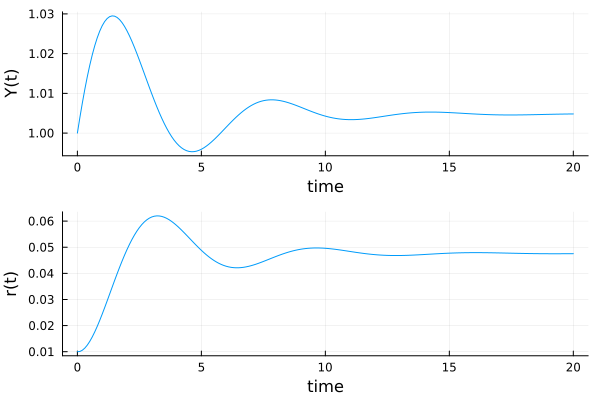

In [6]:
using Parameters, Plots, DynamicalSystems

paras = @with_kw (c_1 = 1.0, c_2 = 1.0, 
                  s = 0.5, a_2 = 1.0, 
                  k_1 = 1.0, k_2 = 0.1, 
                  Ibar = 0.55, Mbar = 1.0 )

function IS_LM!(du, u, p, t)
    c_1, c_2, s, a_2, k_1, k_2, Ibar, Mbar = p
    du[1] = -c_1 * s * u[1]  -c_1 * a_2 * u[2] + c_1 * Ibar
    du[2] = c_2 * k_1 * u[1] -c_2 * k_2 * u[2] - c_2 * Mbar
    return nothing
end
Y_0 = 1.0; r_0 = 0.01
u0 = [Y_0; r_0]

is_lm = CoupledODEs(IS_LM!, u0, paras() )

total_time = 20.0
sampling_time = 0.1
Y, t = trajectory(is_lm, total_time; Ttr=0.0, Δt=sampling_time)
p1 = plot(t, Y[:,1], legend=false, xlabel="time", ylabel="Y(t)")
p2 = plot(t, Y[:,2], legend=false, xlabel="time", ylabel="r(t)")
plot(p1, p2, layout=(2,1) )

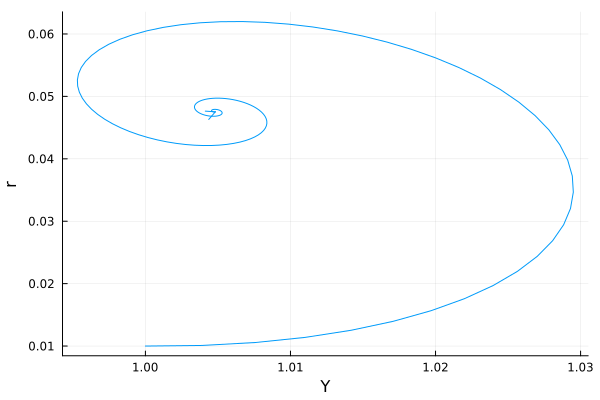

In [7]:
p3 = plot(Y[:,1], Y[:,2], legend=false, xlabel="Y", ylabel="r", arrow=true)

### Chapter6 政府的收支（债务、赤字、税收等）

$ G + iD = T +\dot{D} +\dot{M} $，等号左边为政府支出，等号右边为政府收入。其中
- $G$表示政府支出
- $D$表示存量国债，$\dot{D}$国债的变动（比如新发行国债）
- $i$为国债利率，$iD$表示需要支出的国债利息
- $T$表示税收收入
- $M$表示央行印钱，$\dot{M}$为央行新印出来的钱给政府使用

不考虑央行印钱，模型被简化为$ G + iD = T +\dot{D} $。等号两边同时除以$py$得到$ \dfrac{G + iD}{py} = \dfrac{T+\dot{D}}{py}$，整理后得到$ \dfrac{\dot{D}}{py} = \dfrac{G-T}{py} + \dfrac{iD}{py}$。其中$p$是物价水平，$y$是真实产出，$py$表示名义GDP。令$d=\dfrac{D}{py}$表示债务占GDP的比重，$b=\dfrac{G-T}{py}$表示财政赤子占GDP的比重。最终得到 $ \dfrac{\dot{D}}{py} = b+id $。

$D=dpy$的全微分$\dot{D} = py\dot{d} + p\dot{y}d + \dot{p}yd$，那么$ \dfrac{\dot{D}}{py} = \dot{d} + d \dfrac{\dot{y}}{y} + d \dfrac{\dot{p}}{p} = \dot{d} + d \pi + dg $。其中$\pi = \dfrac{\dot{p}}{p}$表示通货膨胀，$g=\dfrac{\dot{y}}{y}$为实际GDP增长。

联合政府的收支方程和国债的全微分，得到$ \dfrac{\dot{D}}{py} = b+id  = \dot{d} + d \pi + d g $

引入费雪公式 $ r = i - \pi $，实际利率等于名义利率减去通胀。$ b+id  = \dot{d} + d \pi + dg $最终变成了$$ b+(r+\pi)d  = \dot{d} + d \pi + dg  \Rightarrow  \textcolor{red}{  \dot{d} = (r-g) d +b   } $$

如果存在稳态，那么$\dot{d}=0 \Rightarrow d^* = \dfrac{b}{g-r}$

分四种情况讨论该动力系统的稳定性
1. $r-g>0$ 且 $b>0$
2. $r-g>0$ 且 $b<0$
3. $r-g<0$ 且 $b>0$
4. $r-g<0$ 且 $b<0$

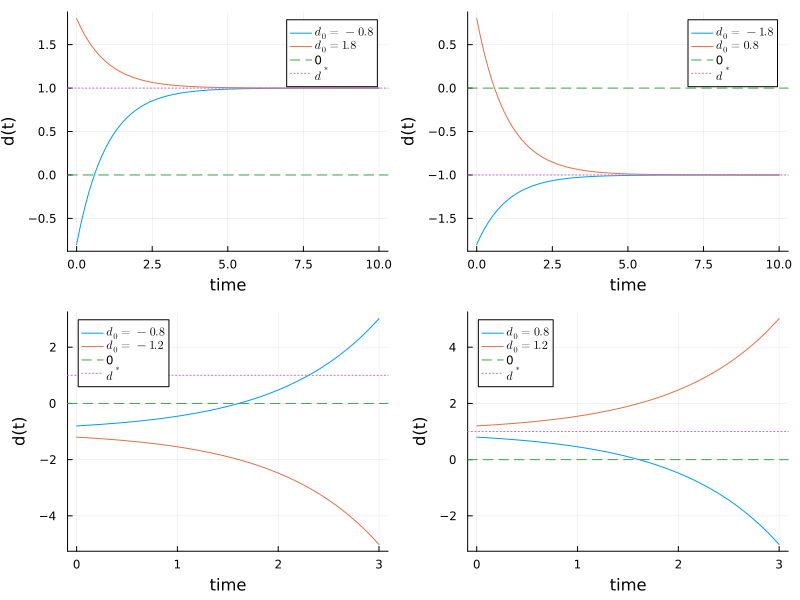

In [8]:
using Parameters, Plots, DynamicalSystems, LaTeXStrings

paras1 = @with_kw ( b = 1.0,  r = 2.0, g = 3.0 )
paras2 = @with_kw ( b = -1.0, r = 2.0, g = 3.0 )
paras3 = @with_kw ( b = 1.0,  r = 3.0, g = 2.0 )
paras4 = @with_kw ( b = -1.0, r = 3.0, g = 2.0 )

function debt_ratio!(du, u, paras, t)
    b, r, g = paras
    du[1] = (r-g)*u[1] + b
    return nothing
end

u0_1 = [-0.8, 1.8]
u0_2 = [-1.8, 0.8]
u0_3 = [-0.8, -1.2]
u0_4 = [0.8, 1.2]

debt_ratio_sol1 = CoupledODEs(debt_ratio!, [u0_1[1]], paras1() )
debt_ratio_sol2 = CoupledODEs(debt_ratio!, [u0_1[2]], paras1() )
debt_ratio_sol3 = CoupledODEs(debt_ratio!, [u0_2[1]], paras2() )
debt_ratio_sol4 = CoupledODEs(debt_ratio!, [u0_2[2]], paras2() )
debt_ratio_sol5 = CoupledODEs(debt_ratio!, [u0_3[1]], paras3() )
debt_ratio_sol6 = CoupledODEs(debt_ratio!, [u0_3[2]], paras3() )
debt_ratio_sol7 = CoupledODEs(debt_ratio!, [u0_4[1]], paras4() )
debt_ratio_sol8 = CoupledODEs(debt_ratio!, [u0_4[2]], paras4() )

total_time1 = 10.0
total_time2 = 10.0
total_time3 = 3.0
total_time4 = 3.0
sampling_time = 0.1
Y1, t1 = trajectory(debt_ratio_sol1, total_time1; Ttr=0.0, Δt=sampling_time)
Y2, t2 = trajectory(debt_ratio_sol2, total_time1; Ttr=0.0, Δt=sampling_time)
Y3, t3 = trajectory(debt_ratio_sol3, total_time2; Ttr=0.0, Δt=sampling_time)
Y4, t4 = trajectory(debt_ratio_sol4, total_time2; Ttr=0.0, Δt=sampling_time)
Y5, t5 = trajectory(debt_ratio_sol5, total_time3; Ttr=0.0, Δt=sampling_time)
Y6, t6 = trajectory(debt_ratio_sol6, total_time3; Ttr=0.0, Δt=sampling_time)
Y7, t7 = trajectory(debt_ratio_sol7, total_time4; Ttr=0.0, Δt=sampling_time)
Y8, t8 = trajectory(debt_ratio_sol8, total_time4; Ttr=0.0, Δt=sampling_time)

plot(t1, [ Y1[:, 1]   Y2[:,1] ], label=[L"d_0=-0.8"  L"d_0=1.8"], xlabel="time", ylabel="d(t)")
hline!([0], ls=:dash, label="0")
p1 = hline!([1], ls=:dot, label=L"d^*")

plot(t3, [ Y3[:, 1]   Y4[:,1] ], label=[L"d_0=-1.8"  L"d_0=0.8"], xlabel="time", ylabel="d(t)")
hline!([0], ls=:dash, label="0")
p2 = hline!([-1], ls=:dot, label=L"d^*")

plot(t5, [ Y5[:, 1]   Y6[:,1] ], label=[L"d_0=-0.8"  L"d_0=-1.2"], xlabel="time", ylabel="d(t)")
hline!([0], ls=:dash, label="0")
p3 = hline!([1], ls=:dot, label=L"d^*")

plot(t7, [ Y7[:, 1]   Y8[:,1] ], label=[L"d_0=0.8"  L"d_0=1.2"], xlabel="time", ylabel="d(t)")
hline!([0], ls=:dash, label="0")
p4 = hline!([1], ls=:dot, label=L"d^*")

plot(p1,p2,p3,p4, layout=(2,2), size=(800, 600))

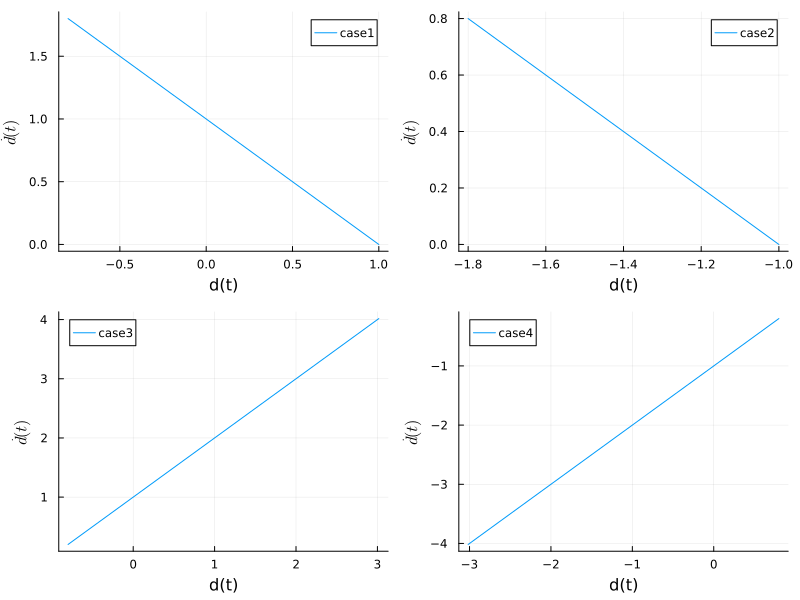

In [9]:
function dd(Y, paras) # dd = (r-g)d + b
    b, r, g = paras
    dd1 = (r-g).*Y .+ b
end

dd1 = dd(Y1[:,1], paras1() )
dd2 = dd(Y2[:,1], paras1() )
dd3 = dd(Y3[:,1], paras2() )
dd4 = dd(Y4[:,1], paras2() )
dd5 = dd(Y5[:,1], paras3() )
dd6 = dd(Y6[:,1], paras3() )
dd7 = dd(Y7[:,1], paras4() )
dd8 = dd(Y8[:,1], paras4() )

p5 = plot(Y1[:,1], dd1, label="case1", xlabel="d(t)", ylabel=L"\dot{d}(t)")
p6 = plot(Y3[:,1], dd3, label="case2", xlabel="d(t)", ylabel=L"\dot{d}(t)")
p7 = plot(Y5[:,1], dd5, label="case3", xlabel="d(t)", ylabel=L"\dot{d}(t)")
p8 = plot(Y7[:,1], dd7, label="case4", xlabel="d(t)", ylabel=L"\dot{d}(t)")

plot(p5,p6,p7,p8, layout=(2,2), size=(800, 600))

### Chapter7 期望与恶性通胀

相比于第四章的凯恩斯乘数和第五章的IS-LM模型，本章引入了宏观框架的微观个体基础

$ M_t^d = e^{-\alpha \pi_{t+1}^e } $，其中$\alpha>0$。该式表示货币需求函数与对未来通胀的期望呈现负相关关系。其背后的逻辑是，个体认为未来的通胀高企时，将减弱现在的货币持有量，降低当前的货币需求。

$ \pi_{t+1}^e = \dfrac{p_{t+1}^e - p_t}{p_t} $，对未来通胀的认知实质来自对未来价格的期望

$\dfrac{M_t^s}{P_t}$，货币供给仅来自中央银行的货币供给，除以价格水平$P$表示真实供给

货币供给与需求相等时，$ \dfrac{M_t^s}{P_t} = e^{ -\alpha \pi_{t+1}^e } \Rightarrow \ln M_t - \ln P_t = - \alpha \pi_{t+1}^e$

令$ \pi_{t+1}^e = \dfrac{P_{t+1}^e - P_t}{P_t}$，当其较小时，进行对数线性化 $ \lim\limits_{x \rightarrow 0} \dfrac{\ln (1+x)}{x} = 1 $，有$ \pi_{t+1}^e = \dfrac{P_{t+1}^e - P_t}{P_t}  \approx \ln (1+ \dfrac{P_{t+1}^e - P_t}{P_t} ) = \ln P_{t+1}^e - \ln P_t $

联合上面几式，有 $ \ln M_t - \ln P_t = - \alpha  (\ln P_{t+1}^e - \ln P_t)  $

改用小写来表示大写字母的自然对数，那么有 $ m_t - p_t = -\alpha (p_{t+1}^e - p_t)  $

整理后可知价格的运动方程 $$ p_t = \dfrac{\alpha}{1+\alpha} p_{t+1}^e + \dfrac{1}{1+\alpha} m_t $$

预期的三种可能
- 简单预期 $ p_{t+1}^e - p_t = \gamma(p_t - p_{t-1}) $， 其中$\gamma>0$，个体简单预期涨<font color="red">势</font>或者跌<font color="red">势</font>

     代入后，得到运动方程 $$ p_t = \dfrac{\alpha}{1+\alpha} p_{t+1}^e + \dfrac{1}{1+\alpha} m_t = \dfrac{\alpha}{1+\alpha} [\gamma(p_t - p_{t-1}) + p_t ] + \dfrac{1}{1+\alpha} m_t = -\dfrac{\alpha \gamma}{1- \alpha \gamma}p_{t-1} + \dfrac{1}{1-\alpha \gamma}m_t $$
     假设货币供给外生给定后，$m_t = \bar{m}$，那么有$p^* = p_t = p_{t-1}= \bar{m} $。 此时考虑偏离稳态的方程则为 $ p_t - p^* = \dfrac{- \alpha \gamma  }{1- \alpha \gamma}(p_{t-1} - p^*) $ 
     
     仅当 $ \left| \dfrac{- \alpha \gamma  }{1- \alpha \gamma} \right| < 1 $时，才能收敛。简化收敛条件为$ 0< \alpha \gamma < \dfrac{1}{2} $
- 完美预期 $ p_{t+1}^e = p_{t+1}$，预期的自我实现，神人流啤。那么运动方程便是 $$ p_{t+1} = \dfrac{1+\alpha}{\alpha} p_t - \dfrac{1}{\alpha} m_t $$
 
    同样假设货币供给外生，那么有 $ p_{t+1} = \dfrac{1+\alpha}{\alpha} p_t - \dfrac{1}{\alpha} \bar{m}  $ 。稳态时，$ p^* = p_{t+1}=p_t= \bar{m} $。 此时考虑偏离稳态的方程则为 $ p_{t+1} - p^* = \dfrac{1+ \alpha   }{ \alpha }(p_t - p^*) $ 
     
     显然这是一个发散的系统，不存在稳定均衡。哪怕价格在稳态，一个微小的扰动就能使之不断发散。


- 理性预期 $ p_{t+1}^e = E_t (p_{t+1})$。那么运动方程便是 $$  p_t = \dfrac{\alpha}{1+\alpha}  E_t (p_{t+1}) + \dfrac{1}{1+\alpha} m_t  $$ 
   $$  p_{t+1} = \dfrac{\alpha}{1+\alpha}  E_{t+1} (p_{t+2}) + \dfrac{1}{1+\alpha} m_{t+1}  $$ 

   对 $ p_{t+1}  $求数学期望，$ E_t(p_{t+1} ) = \dfrac{\alpha}{1+\alpha} E_t [E_{t+1} (p_{t+2})] + \dfrac{1}{1+\alpha} E_t( m_{t+1} ) = \dfrac{\alpha}{1+\alpha} E_t  (p_{t+2}) + \dfrac{1}{1+\alpha} E_t( m_{t+1} )  $，这里$ E_t [E_{t+1} (p_{t+2})] =  E_t  (p_{t+2}) $ 

   代回原$p_t$的运动方程后得到$$ p_t = \dfrac{\alpha}{1+\alpha} \left[ \dfrac{\alpha}{1+\alpha}  E_t  (p_{t+2}) + \dfrac{1}{1+\alpha} E_t( m_{t+1} ) \right] + \dfrac{1}{1+\alpha} m_t = \dfrac{1}{1+\alpha} m_t + \dfrac{1}{1+\alpha}\dfrac{\alpha}{1+\alpha} E_t( m_{t+1} ) + \left( \dfrac{\alpha}{1+\alpha} \right)^2 E_t (p_{t+2}) = \dfrac{1}{1+\alpha} m_t + \dfrac{1}{1+\alpha}\dfrac{\alpha}{1+\alpha} E_t( m_{t+1} ) +  \dfrac{1}{1+\alpha} \left( \dfrac{\alpha}{1+\alpha} \right)^2 E_t (m_{t+2}) + \dots = \dfrac{1}{1+\alpha} \sum\limits_{k=0}^\infty \left( \dfrac{\alpha}{1+\alpha} \right)^k E_t ( m_{t+k} ) $$

换言之，今天的价格水平来自对未来货币供给的期望，时间越靠后，权重$ \left( \dfrac{\alpha}{1+\alpha} \right)^t $越小

如果央行保证货币供给外生恒定，那么$ p_t = \dfrac{\bar{m}}{1+\alpha} \sum\limits_{k=0}^\infty \left( \dfrac{\alpha}{1+\alpha} \right)^k =\bar{m} $

当央行的货币政策不是恒定，有一定选择性的时候$ m_t = \bar{m} + \varepsilon_t$，其中 $E(\varepsilon_t)=0 $。代入$p_t$的运动方程后得到$$ p_t = \dfrac{1}{1+\alpha} \sum\limits_{k=0}^\infty \left( \dfrac{\alpha}{1+\alpha} \right)^k E_t ( m_{t+k} ) = \dfrac{1}{1+\alpha} \varepsilon_t + \bar{m} $$ 
这里$E_t(\varepsilon_t)=\varepsilon_t$，$E_t(\varepsilon_{t+k})=0$

这里插入卢卡斯批判（*The Lucas critique*），宏观政策不仅仅影响各种宏观变量（传统宏观模型中的各种计量模型），还通过改变个体的预期来影响宏观变量（宏观模型中引入了微观基础）
   

简单预期 $ p_{t+1}^e - p_t = \gamma(p_t - p_{t-1}) $， 其中$\gamma>0$。此时的 julia 代码

$\bar{m}=10  $, $p_0 = 11$, 

情况1： $\alpha =0.5$, $\gamma=0.5$ 

情况2： $\alpha =0.8$, $\gamma=0.8$ 

情况3： $\alpha =4.0$, $\gamma=0.8$ 

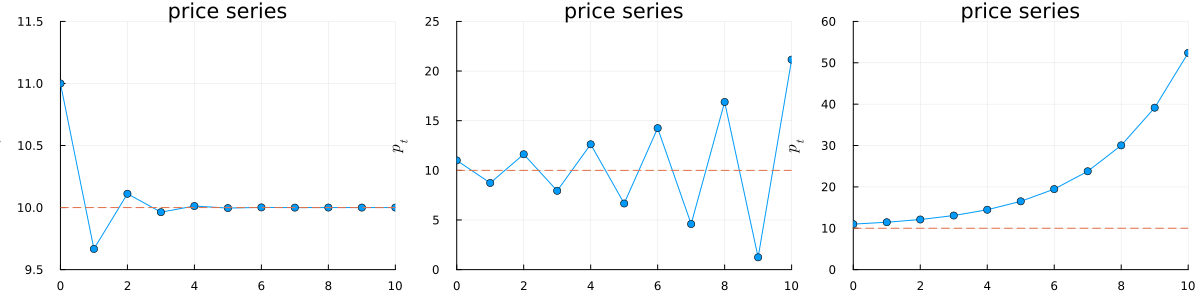

In [10]:
using Parameters, Plots, DynamicalSystems, LaTeXStrings

paras = @with_kw ( m_bar = 10.0,  p_0 = 11.0, alpha = 0.5, gamma = 0.5 )

function naiveExpectation(paras; iters = 11)
    m_bar, p_0, alpha, gamma = paras
    p_series = zeros(iters); p_series[1] = p_0
    for i in 2:iters
        p_series[i] = (m_bar - alpha*gamma * p_series[i-1] ) / (1-alpha*gamma) 
    end
    return p_series
end

periods = 11
p_series1 = naiveExpectation(paras(); iters=periods)
p_series2 = naiveExpectation(paras(alpha=0.7, gamma=0.8); iters=periods)
p_series3 = naiveExpectation(paras(alpha=4.0, gamma=0.8); iters=periods)
plot(0:(periods-1), p_series1, title="price series", legend=false, marker=4, xlabel="t", ylabel=L"p_t", xlims=(0, periods-1), ylims=(9.5, 11.5) )
p1 = hline!([10], ls=:dash )
plot(0:(periods-1), p_series2, title="price series", legend=false, marker=4, xlabel="t", ylabel=L"p_t", xlims=(0, periods-1), ylims=(0, 25) )
p2 = hline!([10], ls=:dash )
plot(0:(periods-1), p_series3, title="price series", legend=false, marker=4, xlabel="t", ylabel=L"p_t", xlims=(0, periods-1), ylims=(0, 60) )
p3 = hline!([10], ls=:dash )
plot(p1, p2, p3, layout=(1,3), size=(1200,300))


完美预期 $ p_{t+1}^e = p_{t+1} $。此时的 julia 代码

$\bar{m}=10  $, $p_0 = 11$, $\alpha =4$


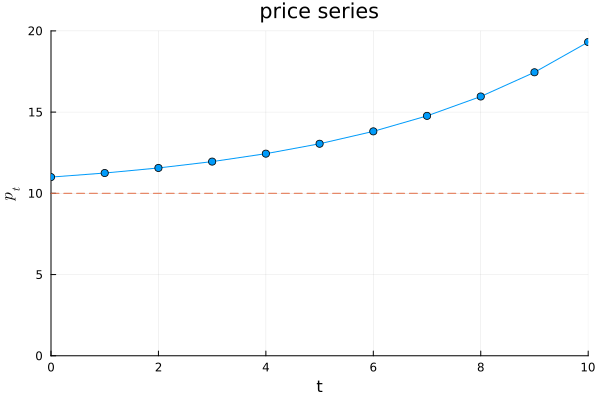

In [11]:
using Parameters, Plots, DynamicalSystems, LaTeXStrings

paras = @with_kw ( m_bar = 10.0,  p_0 = 11.0, alpha = 4.0 )

function perfectExpectation(paras; iters = 11)
    m_bar, p_0, alpha = paras
    p_series = zeros(iters); p_series[1] = p_0
    for i in 2:iters
        p_series[i] = ( (1 + alpha) * p_series[i-1] - m_bar) / alpha
    end
    return p_series
end

periods = 11
p_series = perfectExpectation(paras(); iters=periods)
plot(0:(periods-1), p_series, title="price series", legend=false, marker=4, xlabel="t", ylabel=L"p_t", xlims=(0, periods-1), ylims=(0, 20) )
hline!([10], ls=:dash )


理性预期 $ p_{t+1}^e = E_t (p_{t+1})$。此时的 julia 代码

$\bar{m}=10  $, $p_0 = 10$, $\alpha =4$, $\varepsilon \sim N(0,1)$

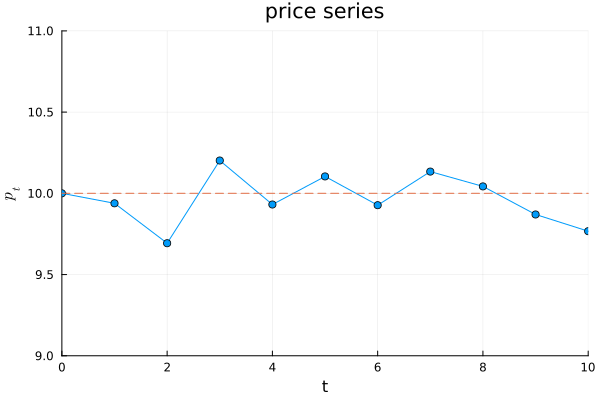

In [12]:
using Parameters, Plots, DynamicalSystems, LaTeXStrings

paras = @with_kw ( m_bar = 10.0,  p_0 = 10.0, alpha = 4.0 )

function rationalExpectation(paras; iters = 11)
    m_bar, p_0, alpha = paras
    p_series = zeros(iters); p_series[1] = p_0
    for i in 2:iters
        epsilon = randn(1)[1]
        p_series[i] = m_bar + epsilon / (1+alpha)
    end
    return p_series
end

periods = 11
p_series = rationalExpectation(paras(); iters=periods)
plot(0:(periods-1), p_series, title="price series", legend=false, marker=4, xlabel="t", ylabel=L"p_t", xlims=(0, periods-1), ylims=(9, 11) )
hline!([10], ls=:dash )

### Chapter8 多恩布什汇率超调模型（Dornbusch Exchange Rate Overshooting Model）

利率平价方程 $ i_{t+1} = i^* + E_t(e_{t+1} - e_t) $，其中$i^*$是外国利率，$ E_t (e_{t+1} - e_t )$表示个体对汇率变化的数学期望

货币需求函数 $ M_t^d = f(i_t, y_t)  $ ，其中利率$i$越高，投资的货币需求越低（利率作为投资的机会成本提升）；产出$y$越高，货币需求也越高。

外生的货币供给$M^s$，从名义值变成实际值后，货币供需平衡有 $ \dfrac{M_t^s}{P_t} = f(i_t, y_t) $

当突然有个未预期到的货币供给冲击时（货币供给增多），总体价格水平变动缓慢，产出也变动缓慢，那么在货币供给平衡方程中，只能由利率来承担这部分货币供给的冲击，利率$i$下跌。
回到利率平价方程，外国利率保持不变，那么利率的下跌由$E_t (e_{t+1} - e_t)$部分承担。更具体的由当前汇率$e_t$上升（本币贬值，以1美元为基准，可以兑换更多的本国货币）。整个过程隐藏的逻辑是，货币市场、汇率市场的反应速度远远快过实际的商品市场。

具体建模时，令$r(t) = \ln[i(t)]$，$r^* = \ln(i^*) $，$e(t)=\ln(E)$，$\dot{e}(t) = \dfrac{de}{dt}=\dfrac{d\ln(E)}{dt}=\dfrac{\dot{E}}{E}$。 那么有利率变动的方程，$r(t) = r^* + \dot{e}(t) $

考虑到理性预期，同时模型是确定性的，没有随机项，那么$E(e)=e$

货币需求函数，具体的形式设为$M^d = Y^\phi e^{-\alpha r}$，其中$\alpha >0$，$\phi>0$，与货币供给联合起来有$ \dfrac{M}{P} = Y^\phi e^{-\alpha r} $。对数化后有，$m-p =  \phi y^F - \alpha*r $，其中$m=\ln(M)$，$p=\ln(P)$，$y^F=\ln(Y)$。这里，$y^F$表示完全就业时的产出水平，F为full

整理后可得，$ p-m = - \phi y^F + \alpha [ r^*+ \dot{e}(t) ] $

市场均衡时，价格水平稳定，汇率不再变动，有  $ \bar{p} - m = - \phi y^F + \alpha  r^* $，其中$r^*$表示外国利率

两式相减可知， $ \dot{e} = \dfrac{1}{\alpha} (p - \bar{p}) $

经济体的总需求 $\ln (D) \equiv d = v+ \beta(e-p ) +\gamma y - \sigma r $，该式类似回归方程，其中$v$是截距项，$\beta, \gamma, \sigma$均为回归方程的系数。

由于总产出已经达到$y^F$，额外的需求只能通过价格来反应，有 $ \dot{p} = \theta(d-y^F) = \theta [ v+ \beta(e-p ) +(\gamma-1) y - \sigma r ] $

最终有了汇率和价格水平的运动方程
- $ \dot{e} = \dfrac{1}{\alpha} (p - \bar{p}) $
- $ \dot{p} = \theta(d-y^F) = \theta [ v+ \beta(e-p ) +(\gamma-1) y - \sigma r ] $

当均衡时，显然 $\dot{e}=\dot{p}=0$，有 $ \bar{e} = \bar{p} + \dfrac{1}{\beta} [(1- \gamma) y + \sigma r^* - v  ]  $

式$ \dot{p} = \theta(d-y^F) = \theta [ v+ \beta(e-p ) +(\gamma-1) y - \sigma r ] $，考虑原始货币市场均衡 $ m -p = \phi y - \alpha r$

消去$r$可得，$  \dot{p} = \theta [ v+ \beta(e-p ) +(\gamma-1) y - \sigma r ] =  \theta \left[ v+ \beta(e-p ) +(\gamma-1) y - \sigma \dfrac{\phi y +p-m}{\alpha} \right] = \theta \beta(e-p ) + \theta \left[ v - (\dfrac{\sigma \phi}{\alpha} + 1- \gamma) y + \dfrac{\sigma}{\alpha} (m-p) \right] $

稳态时，$\dot{p}=0 = \theta \beta(\bar{e}-\bar{p} ) + \theta \left[ v - (\dfrac{\sigma \phi}{\alpha} + 1- \gamma) y + \dfrac{\sigma}{\alpha} (m-\bar{p}) \right] $

$\dot{p}$减去$\dot{p}=0$的表达式，可得 $\dot{p} = \theta \beta (e-p -\bar{e}+\bar{p}) + \theta \dfrac{\sigma}{\alpha} (\bar{p} - p) = \theta \beta (e - \bar{e}) - \theta(\beta + \dfrac{\sigma}{\alpha} )(p - \bar{p})$

最终偏离稳态的两个运动方程为
- $ \dot{e} = \dfrac{1}{\alpha} (p - \bar{p}) $
- $ \dot{p} = \theta \beta (e - \bar{e}) - \theta \left(\beta + \dfrac{\sigma}{\alpha} \right)(p - \bar{p})$

改写成矩阵的形式

$ \left( \begin{array}{l} \dot{e} \\ \dot{p} \end{array} \right) = \left( \begin{array}{cc} 0 & \dfrac{1}{\alpha} \\ \theta \beta & - \theta \left(\beta + \dfrac{\sigma}{\alpha} \right) \end{array} \right)  \left( \begin{array}{l} e - \bar{e} \\ p - \bar{p} \end{array} \right) $

动力系统的稳定性，考察矩阵$ J = \left( \begin{array}{cc} 0 & \dfrac{1}{\alpha} \\ \theta \beta & - \theta \left(\beta + \dfrac{\sigma}{\alpha} \right) \end{array} \right) $的特征值 $ \dfrac{1}{2} \left[-\theta \left(\beta + \dfrac{\sigma}{\alpha} \right) \pm \sqrt{\theta^2 \left(\beta + \dfrac{\sigma}{\alpha} \right)^2 + 4\dfrac{\theta \beta}{\alpha} } \right] $ 

这两个特征值一正一负，沿着负特征值对应特征向量的方向稳定，一系列马鞍点，沿着正特征值对应特征向量的方向发散

In [13]:
using Parameters, Plots, DynamicalSystems

paras = @with_kw (alpha = 1.0, beta = 1.0, sigma=1.0, theta=0.5, e_bar=2, p_bar=2)

function overshooting!(du, u, paras, t)
    alpha, beta, sigma, theta, e_bar, p_bar = paras
    du[1] = (u[2] - p_bar) / alpha
    du[2] = theta* beta*(u[1] - e_bar) - theta*(beta+sigma/alpha)*(u[2]-p_bar)
    return nothing
end
e_0_1 = 3.0; p_0_1 = 1.0
e_0_2 = 2.4; p_0_2 = 1.0
e_0_3 =2.7321; p_0_3 = 1.0
u0_1 = [e_0_1; p_0_1]
u0_2 = [e_0_2; p_0_2]
u0_3 = [e_0_3; p_0_3]

dornbusch1 = CoupledODEs(overshooting!, u0_1, paras() )
dornbusch2 = CoupledODEs(overshooting!, u0_2, paras() )
dornbusch3 = CoupledODEs(overshooting!, u0_3, paras() )

total_time = 5.0
sampling_time = 0.1
Y1, t1 = trajectory(dornbusch1, total_time; Ttr=0.0, Δt=sampling_time)
Y2, t2 = trajectory(dornbusch2, total_time; Ttr=0.0, Δt=sampling_time)
Y3, t3 = trajectory(dornbusch3, total_time; Ttr=0.0, Δt=sampling_time)
p1 = plot(t, [Y1[:,1] , Y2[:,1] , Y3[:,1]], legend=false, xlabel="time", ylabel="e(t)")
p2 = plot(t, [Y1[:,2] , Y2[:,2] , Y3[:,2]], legend=false, xlabel="time", ylabel="p(t)")
plot(p1, p2, layout=(2,1) )

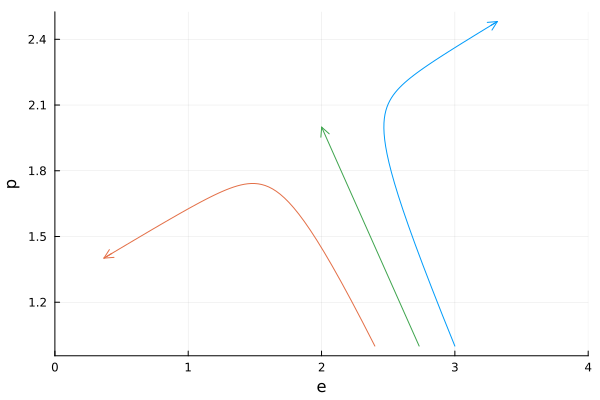

In [14]:
plot(Y1[:,1], Y1[:,2], legend=false, xlabel="e", ylabel="p", xlims=(0, 4), arrow=true)
plot!(Y2[:,1], Y2[:,2], legend=false, xlabel="e", ylabel="p", xlims=(0, 4), arrow=true)
plot!(Y3[:,1], Y3[:,2], legend=false, xlabel="e", ylabel="p", xlims=(0, 4), arrow=true)

### Chapter9 索洛增长模型（Solow Growth Model）

生产函数 $Y= F(K, AL) \Rightarrow  \dfrac{Y}{AL} = F(\dfrac{K}{AL}, 1) = f(\dfrac{K}{AL})$，最终有 $y = f(k)$，其中$y=\dfrac{Y}{AL}$，$k=\dfrac{K}{AL}$

满足稻田条件（Inada conditions），$ \lim\limits_{k \rightarrow 0^+} \dfrac{dy}{dk} = \infty$ 以及 $ \lim\limits_{k \rightarrow \infty} \dfrac{dy}{dk} = 0 $

$ Y = C + I $，还有$ S =sY = I $

资本的变化 $\dfrac{dK}{dt} = I - \delta K$，其中 $0<\delta<1$表示资本的折旧率

人口和技术的自然增长分别为 $L(t) = L(0) e^{nt}$ 和 $A(t) = A(0) e^{gt}$

联合几个式子写成资本和产出的方程有， $ sY = \dfrac{dK}{dt} + \delta K \Rightarrow s\dfrac{Y}{AL} = \dfrac{1}{AL} \dfrac{dK}{dt} + \delta \dfrac{K}{AL} \Rightarrow sy = \dfrac{1}{AL} \dfrac{dK}{dt} + \delta k $

计算 $\dfrac{dk}{dt} = \dfrac{d \dfrac{K}{AL} }{dt} = \dfrac{1}{AL} \dfrac{dK}{dt} + K \dfrac{d \dfrac{1}{AL}}{dt} = \dfrac{1}{AL} \dfrac{dK}{dt} - \dfrac{K}{(AL)^2} \dfrac{d (AL)}{dt} = \dfrac{1}{AL} \dfrac{dK}{dt} - \dfrac{K}{(AL)^2} \left(A\dfrac{dL}{dt} + L \dfrac{dA}{dt} \right) =  \dfrac{1}{AL} \dfrac{dK}{dt} - \dfrac{K}{AL} \left(\dfrac{1}{L} \dfrac{dL}{dt} + \dfrac{1}{A} \dfrac{dA}{dt} \right) = \dfrac{1}{AL} \dfrac{dK}{dt} - \dfrac{K}{AL} \left( \dfrac{d\ln L}{dt} +  \dfrac{d \ln A}{dt} \right) =  \dfrac{1}{AL} \dfrac{dK}{dt} - \dfrac{K}{AL} (n+g) $

所以，$ \dfrac{1}{AL} \dfrac{dK}{dt} = \dfrac{dk}{dt} +  \dfrac{K}{AL} (n+g) = \dfrac{dk}{dt} +  k(n+g) $

最终有，$  sy = \dfrac{dk}{dt} +  k(n+g) + \delta k = \dfrac{dk}{dt} +  k(n+g+\delta) \Rightarrow \dfrac{dk}{dt} = sy - k(n+g+\delta) $

令 生产函数$F$的表达式为Cobb-Douglas式，即$ Y= F(K,AL) = K^\alpha (AL)^{1-\alpha}$，其中$0<\alpha<1$，可推导出$y=k^\alpha$。

那么，资本$k$的运动方程为 $\dfrac{dk}{dt} = sk^\alpha - k(n+g+\delta)$。当$\dfrac{dk}{dt}=0$时，$k$处于稳态，可解出$ \bar{k} = \left( \dfrac{n+g+\delta}{s} \right)^\dfrac{1}{\alpha-1}=\left( \dfrac{s}{n+g+\delta} \right)^\dfrac{1}{1-\alpha}$

当 $k$处于稳态点时，即$k = \left( \dfrac{s}{n+g+\delta} \right)^\dfrac{1}{1-\alpha}$时，考察其稳定性。一个小的正向抖动 $ \dfrac{d}{dk} \left( \dfrac{dk}{dt} \right) \left|_{k=\left( \frac{s}{n+g+\delta} \right)^\frac{1}{1-\alpha}} \right. = \alpha sk^{\alpha-1} - (n+g+\delta) = (\alpha-1)(n+g+\delta) < 0 $。所以 $\bar{k}$是稳定的。

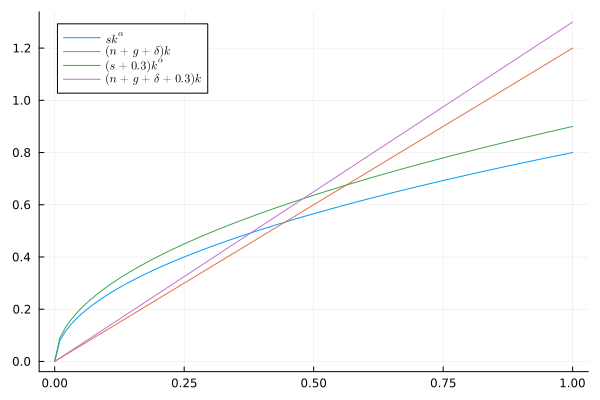

In [15]:
using Parameters, Plots, DynamicalSystems, LaTeXStrings

paras = @with_kw (s = 0.8, alpha = 0.5, n = 0.5, g = 0.3, delta = 0.4)
s, alpha, n, g, delta = paras()

k = 0:0.01:1
plot(k, [s.*k.^alpha   (n+g+delta).*k ], label=[L"sk^\alpha"  L"(n+g+\delta)k"] )
plot!(k, [(s+0.1).*k.^alpha    (n+g+delta+0.1).*k ], label=[L"(s+0.3)k^\alpha"   L"(n+g+\delta+0.3)k" ] )

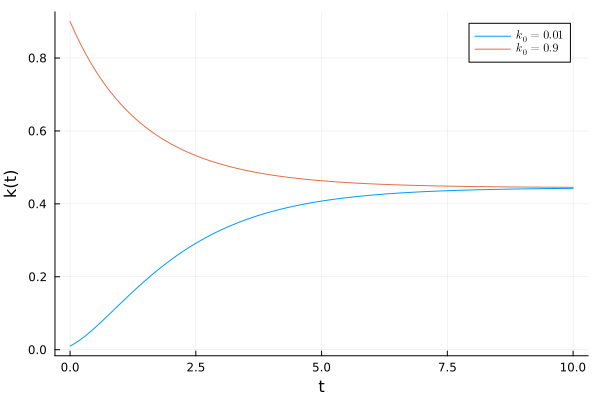

In [16]:
function solow!(du, u, paras, t)
    s, alpha, n, g, delta = paras
    du[1] = s.*u[1].^alpha - (n+g+delta).*u[1]
    return nothing
end

u0_low = [  0.01 ]
u0_high= [ 0.9 ]

solow_model_low = CoupledODEs(solow!, u0_low, paras() )
solow_model_high = CoupledODEs(solow!, u0_high, paras() )
total_time = 10.0
sampling_time = 0.1

Y_low, t_low = trajectory(solow_model_low, total_time; Ttr=0.0, Δt=sampling_time)
Y_high, t_high = trajectory(solow_model_high, total_time; Ttr=0.0, Δt=sampling_time)
plot(t_low, [Y_low[:,1]  Y_high[:,1]], xlabel="t", ylabel="k(t)", label=[L"k_0 = 0.01"    L"k_0=0.9"])

### Chapter10 内生增长模型

在索洛模型中，$k=\dfrac{K}{AL}$保持在稳态$\bar{k}$，那么经济产出$Y$的增长完全来自人口的增长$n$和技术的增长$g$两个模型外生的部分，本章考察内生增长。

非竞争性的知识与技术造就了内生增长，非竞争性的定义，我对该物品的使用并不降低其他人对该物品的使用，换言之，边际成本为0。

在生产函数中，不再是规模报酬不变（constant return to scale），而是规模报酬递增（increasing return to scale）。

比如，在AK模型中
- 知识生产函数 $ Y(t) = AK(t) $
- 资本积累方程 $ \dot{K}(t) = sY(t) - nK(t) = (sA-n)K(t)  \Rightarrow \dfrac{\dot{K}}{K} = sA-n$


令人感兴趣的是知识技术到底是怎么变化的？即 $\dfrac{dA(t)}{dt}$ 如何变化？

假设一个没有政府部门的封闭经济体，仅包含有产品产出部门和知识产出部门
- 产品生产函数 $ Y(t) = [(1-a_K) K(t)]^\alpha [A(t)(1-a_L) L(t) ]^{1-\alpha}  $，其中$0<\alpha<1$
- 知识的运动方程 $ \dot{A}(t) = B[a_K K(t)]^\beta [a_L L(t)]^\gamma A(t)^\theta $，其中$ B>0$，$\beta \geq 0$，$\gamma \geq 0$，$\theta \in \mathbb{R}$ 

注意到，知识的运动方程并不遵从规模报酬不变

人口增长$\dot{L}(t) = nL(t)$，其中$n>0$。资本增长$\dot{K}(t) = sY(t)$，其中储蓄率$s>0$，没有折旧。

综合得到资本的增速和知识的增速
- $ g_K(t) \equiv \dfrac{\dot{K}}{K} = s (1-a_K)^\alpha (1-a_L)^{1-\alpha} \left[\dfrac{A(t)L(t)}{K(t)} \right]^{1-\alpha}$
- $ g_A(t) \equiv \dfrac{\dot{A}}{A} = B[a_K K(t)]^\beta [a_L L(t)]^\gamma A(t)^{\theta-1}$

取自然对数后
- $ \ln g_K(t) = \ln s + \alpha \ln(1-a_K) + (1-\alpha) \ln(1-a_L) + (1-\alpha) [\ln A(t) + \ln L(t) - \ln K(t)] $
- $ \ln g_A(t) = \ln B + \beta [\ln a_K + \ln K(t)] + \gamma [\ln a_L + \ln L(t)] + (\theta-1) \ln A(t) $

再对t求导数
- $ \dot{g}_K(t) = (1-\alpha) \left[ g_A(t) + n - g_K(t) \right] g_K(t) $ 
- $ \dot{g}_A(t) = \left[ \beta g_K(t) + \gamma n + (\theta -1) g_A(t) \right] g_A(t) $

这构成了$g_K(t)$和$g_A(t)$的<font color="red">非线性</font>动力系统。

稳态时，$ \dot{g}_K(t) = \dot{g}_A(t) = 0$，那么有
- $(1-\alpha) \left[ g_A(t) + n - g_K(t) \right] g_K(t)=0  \Rightarrow g_K(t)=0 $ 或者 $ g_A(t) + n - g_K(t)=0 $
- $ \left[ \beta g_K(t) + \gamma n + (\theta -1) g_A(t) \right] g_A(t)=0 \Rightarrow g_A(t)=0 $ 或者 $ \beta g_K(t) + \gamma n + (\theta -1) g_A(t) =0 $

$g_A(t)=0 $ 以及 $ g_K(t)=0 $都意味着资本$K$和$A$不再变化，这显然与事实不符合。所以唯一的均衡点同时满足 $ g_A(t) + n - g_K(t)=0 $ 和 $ \beta g_K(t) + \gamma n + (\theta -1) g_A(t) =0 $。

可以求解得到 $ g_K^*(t) =  \dfrac{n(\beta+\gamma)}{1-\beta-\theta} + n$ 和 $g_A^*(t) = \dfrac{n(\beta+\gamma)}{1-\beta-\theta} $

非线性动力系统在稳态点处的稳定性，仍是把非线性动力系统在稳态点处taylor展开到一阶线性情况，再讨论。比如此处的Jacobian矩阵为

$ J(g_K^*, g_A^*) = \left(  \begin{array}{ll} \frac{\partial \dot{g_K}}{\partial g_K}\left|_{(g_K^*, g_A^*)} \right. & \frac{\partial \dot{g_K}}{\partial g_A}\left|_{(g_K^*, g_A^*)} \right. \\ 
\frac{\partial \dot{g_A}}{\partial g_K}\left|_{(g_K^*, g_A^*)} \right. & \frac{\partial \dot{g_A}}{\partial g_A}\left|_{(g_K^*, g_A^*)} \right. \end{array} \right) = \left( \begin{array}{cc} (1-\alpha)(g_A^*+n-2g_K^*) & (1-\alpha) g_K^* \\ \beta g_A^* & \beta g_K^* + \gamma n + 2(\theta-1)g_A^* \end{array} \right) $

代入$g_K^*$和$g_A^*$的表达式以后，可得 $ J(g_K^*, g_A^*) = \dfrac{n}{1-\beta-\theta} \left(  \begin{array}{cc} (\alpha-1)(1+\gamma-\theta)  & (1-\alpha)(1+\gamma-\theta)  \\ \beta (\beta+\gamma) &    (\beta+\gamma)(\theta-1) \end{array} \right) $

求特征值可以使用 Python的 sympy 包进行


In [17]:
using DifferentialEquations

function twoSector!(du, u, p, t)
    alpha, beta, gamma, theta, nn = p
    du[1] = (u[2] + nn - u[1]) * (1-alpha) * u[1]
    du[2] = (beta* u[1] + gamma*nn - (theta-1)*u[2] ) * u[2]
    return nothing
end

alpha = 0.5
beta = 0.2
gamma = 2.0
theta = 0.5
nn = 1.0
g_k0 = 14.0; g_a0 = 1.0
u0 = [g_k0, g_a0]
p0 = [ alpha, beta, gamma, theta, nn]

tspan = (0.0, 10.0)
prob = ODEProblem(twoSector!, u0, tspan, p0)
sol = solve(prob, Tsit5() )
print(sol.t)
print(sol.u)
# 这里会碰到问题，dt时间太小，比dtmin更小，导致无法继续进行下去
# 如果把dtmin设置成0，又会遇到 max_iter 超过的问题
# 这里只能用 MATLAB 求解
# root cause 来自 MATLAB的 ode45 函数和 julia 各个包中的函数不同

[0.0, 0.04446645706027464, 0.0854238128674425, 0.15029794438625782, 0.2222707766963446, 0.31635336016344295, 0.41621593429058945, 0.5098867204423365, 0.5413648552919926, 0.5590438804088105, 0.5690366873755914, 0.5738801195008355, 0.5764348092018923, 0.5777838165786168, 0.5784778249633348, 0.5788401702753998, 0.5790294563643982, 0.5791279066096429, 0.5791792494022947, 0.5792060331126365, 0.5792199964574523, 0.5792272802649145, 0.5792310804429357, 0.5792330630979249, 0.5792340977013902, 0.579234637650864, 0.579234919467932, 0.5792350665732808, 0.5792351433676323, 0.5792351834602588, 0.5792352043933962, 0.5792352153237889, 0.5792352210315574, 0.5792352240123018, 0.579235225569017, 0.579235226382068, 0.5792352268067361, 0.5792352270285575, 0.5792352271444291, 0.5792352272049591, 0.5792352272365807, 0.5792352272531008, 0.5792352272617318, 0.5792352272662412, 0.5792352272685973, 0.5792352272698285, 0.5792352272704717, 0.5792352272708079, 0.5792352272709835, 0.5792352272710753, 0.579235227271

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5792352272711738, and step error estimate = 42.823842222328615. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase D:\julia_packages\packages\SciMLBase\VS2ST\src\integrator_interface.jl:599


[[14.0, 1.0], [11.130797543606427, 1.2517269678934986], [9.475021735014327, 1.5199662745219482], [7.846710619941944, 2.0489021849092306], [6.830496046458119

, 2.8681903126936907], [6.2693351745730705, 4.647213627186131], [6.616341329838885, 8.873934562325964], [9.52134467071849, 24.236704860878294], [13.678213787733238, 46.729515754525266], [20.982215633761538, 90.43450559267065], [34.714499724966615, 182.72966345482206], [57.26583744364805, 352.22531561278134], [96.5256455287125, 679.1052868292926], [166.25853272898306, 1318.137497892968], [287.99279940824096, 2537.204449726485], [503.649933906999, 4881.426616713834], [888.6211258557465, 9398.764642589444], [1576.1682516008225, 18064.106650355316], [2810.9657058300677, 34703.918459547116], [5037.737100430996, 66661.89942605133], [9063.660634616273, 127978.11186897209], [16365.570284054113, 245620.16420181628], [29645.57730093373, 471299.14189533266], 

[53853.20444715597, 904090.4703232832], [98078.87971900153, 1.733947667953066e6], [179039.42833002986, 3.324925843500467e6], [327516.9418609352, 6.374584869873144e6], [600279.1498537686, 1.2219551104719736e7], [1.1021431297930279e6, 2.3420637444490068e7], [2.026868764378681e6, 4.488347973241122e7], [3.7330365246677813e6, 8.600500174198788e7], [6.884932349194048e6, 1.6478378335261685e8], [1.2714364984359061e7, 3.156910067598165e8], [2.3507620259268954e7, 6.04742093519231e8], [4.351179128843318e7, 1.1583541754537725e9], [8.062283847256072e7, 2.2185958190070143e9], [1.4953181077762368e8, 4.248963271431355e9], [2.775924719533051e8, 8.136879138376131e9], [5.1577077603890395e8, 1.5581335491734093e10], 

[9.590897164057778e8, 2.9834940785624943e10], [1.7848242261783516e9, 5.7124305730303665e10], [3.3238942985989723e9, 1.0936877021801094e11], [6.194379666569551e9, 2.093841025834367e11], [1.1551327103755903e10, 4.008420383335864e11], [2.1554359258055973e10, 7.673316103145952e11], [4.02433698835546e10, 1.468839127701418e12], [7.517912585710606e10, 2.8115617004783564e12], [1.4051817878943604e11, 5.381509690511186e12], [2.6277825645112076e11, 1.0300173881724547e13], [4.9165236763673834e11, 1.9713770524869953e13], [9.202998204888336e11, 3.772942745463766e13], [1.7234328924360469e12, 7.220658083068836e13], [3.2288297068180586e12, 1.3818471878398572e14], [6.051652177060336e12, 2.644420178190555e14], [1.1346808270024049e13, 5.0604449100200506e14], [2.128323530077715e13, 9.683563760345714e14]]

### Chapter11 萨缪尔森的乘数-加速数模型（multiplier-accelerator model）

封闭的经济体，考虑离散形式

$ C_t = b Y_{t-1}  $, 其中$0<b<1$表示边际消费倾向

$ I_t = I_t^g + I_t^p $，其中 $I_t^g = G > 0$表示自动投资

$ I_t^p = k(C_t - C_{t-1}) $，其中 $k>0$，表示消费引致的投资。如果消费增大了，那么对应需要投资生产更多。

$ Y_t = C_t + I_t $

综合以上几个方程可以得到 $ Y_t = b Y_{t-1} + G + kb( Y_{t-1} - Y_{t-2}  )  $，整理后得到运动方程 
$$ Y_t - b(1+k)Y_{t-1} +bkY_{t-2} =G $$ 

稳态时，$Y^* = \dfrac{G}{1-b} $


二阶线性差分方程求解 $ A x_{n+2} + B x_{n+1} + C x_n = 0 $，猜测方程的解为 $x_n = m^n$， $m \neq 0 $，那么有 $ A m^2 + B m + C =0 $，解出 $m = \dfrac{-B \pm \sqrt{B^2 - 4AC} }{2A}$

那么$Y_t$的特征根为$ \mu_{1,2} = \dfrac{1}{2} [b(1+k) \pm \sqrt{b^2(1+k)^2 -4 bk} ] $

- 根号里的 $\Delta>0$时， $ Y_t = c_1 \mu_1^t + c_2 \mu_2^t $
- 根号里的 $\Delta=0$时， $ Y_t = c_1 \left( \dfrac{b+bk}{2} \right)^t + c_2 t \left( \dfrac{b+bk}{2} \right)^t $
- 根号里的 $\Delta<0$时， $ Y_t = r^t [ c_1 sin(\theta t) + c_2 cos(\theta t ) ] $，其中$r = |\mu_i|$，$\theta = tan^{-1} \left( \dfrac{image(\mu_i)}{real(\mu_i)}  \right) $，$i \in \{1,2 \}$

综合 通解和特解得到
$$ Y_t = \dfrac{G}{1-b} + \left\{ \begin{array}{ll} c_1 \mu_1^t + c_2 \mu_2^t & \Delta >0 \\ c_1 \mu^t + c_2 t \mu^t & \Delta=0 \\ r^t [ c_1 sin(\theta t) + c_2 cos(\theta t ) ] & \Delta < 0  \end{array} \right. $$ 

考察稳定性，要求$|\mu_1| < 1$和$| \mu_2|<1$

### 插入一段二阶线性差分方程稳定性相关内容

$ A x_{t+2} + B x_{t+1} + C x_t = G $

特解时，在$x^*$，那么 $ A x^* + B x^* + C x^* =G $可得 $x^* = \dfrac{G}{A+B+C} $

通解时有 $ A x_{t+2} + B x_{t+1} + C x_t = 0  $，假设 $x_t = m^t$，那么 $x_{t+1}= m^{t+1}$，$x_{t+2} = m^{t+2}$，代入原方程即为 $  A m^{t+2} + B m^{t+1} + C m^t = 0 $  ，约去$m^t$获得一元二次方程 $ A m^2 + B m +C =0 $求解得到 
- $\Delta >0$时，$ m_1 = \dfrac{-B + \sqrt{B^2 -4AC}}{2A} $，$ m_2 = \dfrac{-B - \sqrt{B^2 -4AC}}{2A} $，对应差分方程的解 $  x_t = c_1 m_1^t + c_2 m_2^t$
- $\Delta =0$时，$ m_1 = m_2 = m = \dfrac{-B}{2A} $，对应差分方程的解 $  x_t = c_1 m^t + c_2 t m^t$
- $\Delta <0$时，$ m_1 = \dfrac{-B + i\sqrt{4AC - B^2}}{2A} $，$ m_2 = \dfrac{-B - i \sqrt{4AC-B^2}}{2A} $，实部为 $\dfrac{-B}{2A}$，虚部为$\pm \dfrac{\sqrt{4AC-B^2}}{2A}$，为了转换成三角函数的形式 实部的平方加虚部的平方，凑成1
  
$ \left( \dfrac{-B}{2A} \right)^2 +  \left( \pm \dfrac{\sqrt{4AC-B^2}}{2A} \right)^2 = \dfrac{C}{A} $

等号两边同时除以 $ \sqrt{\dfrac{C}{A}} $，即可转化为三角函数 $ \cos^2 \theta + \sin^2 \theta = 1$的形式。

显然， $\cos \theta = \dfrac{-B}{2A} / \sqrt{\dfrac{C}{A}} = \dfrac{-B}{2A} \sqrt{\dfrac{A}{C}}  $， $ \sin \theta = \pm \dfrac{\sqrt{4AC-B^2}}{2A} / \sqrt{\dfrac{C}{A}}= \pm \dfrac{1}{2A} \sqrt{4A^2 - \dfrac{A}{C} B^2} $

那么，当 $\Delta <0$时，$ m_1 = r (\cos \theta + i \sin \theta) $， $ m_2 = r (\cos \theta - i \sin \theta) $。这里的  $r = \sqrt{\dfrac{C}{A}} $

把$A x_{t+2} + B x_{t+1} + C x_t = 0 $改写成 $ x_{t+2} + \dfrac{B}{A} x_{t+1} + \dfrac{C}{A} x_t = 0 $。 记$b = \dfrac{B}{A}$，$c=\dfrac{C}{A}$，二阶线性差分方程 $ x_{t+2} + b x_{t+1} + c x_t = 0 $稳定要求 
- $\Delta >0$时，$| m_1 | < 1$，$ | m_2 | < 1 $。  $ -1 < \dfrac{-b \pm \sqrt{b^2 - 4c} }{2}  < 1 $，自然有 $ b-2 <  \pm \sqrt{b^2 - 4c} < b+2$，那么 $-2<b<2$，$\Delta>0$也必然要求 $c<1$
    
     拆出两个不等式 $  \left\{  \begin{array}{l} \sqrt{b^2 - 4c} < b+2   \\ b-2 <  - \sqrt{b^2 - 4c}  \end{array} \right.  \Rightarrow   \left\{  \begin{array}{l} 1+c>-b  \\ 1+c> b  \end{array} \right. $
- $\Delta =0$时，$| m | < 1 $。即， $ \left| \dfrac{-b}{2} \right| < 1  $ 
- $\Delta <0$时，$| r | < 1 $。

回到原二阶线性差分方程 $ Y_t - b(1+k)Y_{t-1} +bkY_{t-2} =G $

$\Delta = b^2(1+k)^2 - 4bk$，  判断$\Delta$大于小于等于0，即判断 $ b  <=> \dfrac{4k}{(1+k)^2} $
- $ \Delta >0 $，即 $ b >  \dfrac{4k}{(1+k)^2}$，收敛的条件是 $ 1 + bk > | -b(1+k) | $ 和 $bk < 1 $ 。 不难发现   $bk < 1$时，收敛； $bk \geq 1$时，发散。
- $ \Delta =0 $，即 $ b =  \dfrac{4k}{(1+k)^2}$，收敛的条件是 $  \left| \dfrac{b(1+k)}{2} \right| < 1  $
- $ \Delta <0 $，即 $ b <  \dfrac{4k}{(1+k)^2}$，收敛的条件是 $ bk <1 $

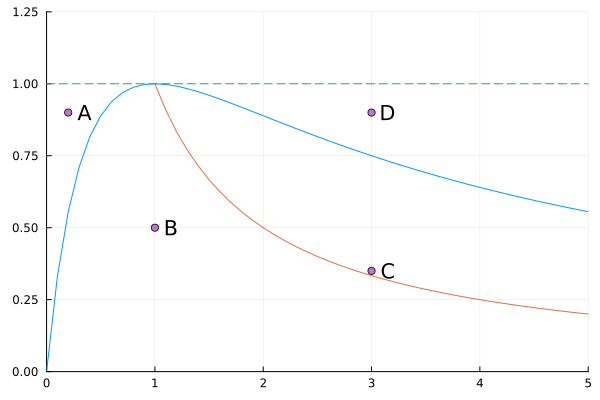

In [18]:
using  Plots, DynamicalSystems

k = range(start=0, stop=5, step=0.1)
k2 = range(start=1, stop=5, step=0.1)
A = (0.2, 0.9)
B = (1.0, 0.5)
C = (3.0, 0.35)
D = (3.0, 0.9)

plot(k, k -> 4k/(1+k)^2  , xlims=(0,5), ylims=(0,1.25), legend=false  )
plot!(k2, k2 -> 1/k2)
hline!([1], ls=:dash)
scatter!([A, B, C, D] )
annotate!( [(0.35, 0.9, "A") , (1.15,0.5,"B") , (3.15,0.35,"C") , (3.15,0.9,"D") ] ) 

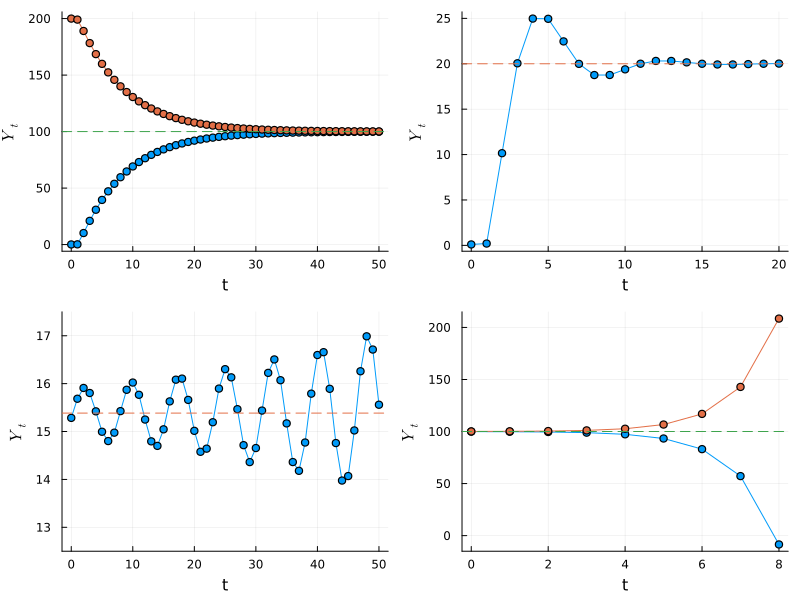

In [19]:
using LaTeXStrings

G=10

k = A[1] ; b = A[2]
YA1_0 = 0.1; YA1_1 = 0.2
YA2_0 = 200; YA2_1 = 199.1

tA = 50
YA1 = zeros(tA+1); YA2 = zeros(tA+1)
YA1[1] = YA1_0; YA1[2] = YA1_1
YA2[1] = YA2_0; YA2[2] = YA2_1
for i in 3:(tA+1)
    YA1[i] = G + b*(1+k)*YA1[i-1] - b*k*YA1[i-2]
    YA2[i] = G + b*(1+k)*YA2[i-1] - b*k*YA2[i-2]
end

Y_steady = G/(1-b)
plot(0:tA, YA1, legend=false, marker=4, xlabel="t", ylabel=L"Y_t")
plot!(0:tA, YA2, marker=4)
p1 = hline!([Y_steady], ls=:dash)
########################################################################
k = B[1]; b = B[2]
YB_0 = 0.1; YB_1 = 0.2

tB = 20
YB = zeros(tB+1)
YB[1] = YB_0; YB[2] = YB_1
for i in 3:(tB+1)
    YB[i] = G + b*(1+k)*YB[i-1] - b*k*YB[i-2]
end

Y_steady = G/(1-b)
plot(0:tB, YB, legend=false, marker=4, xlabel="t", ylabel=L"Y_t")
p2 = hline!([Y_steady], ls=:dash)
########################################################################
k = C[1]; b = C[2]
YC_0 = G/(1-b)-0.1; YC_1 =G/(1-b) + 0.3

tC = 50
YC = zeros(tC+1)
YC[1] = YC_0; YC[2] = YC_1
for i in 3:(tC+1)
    YC[i] = G + b*(1+k)*YC[i-1] - b*k*YC[i-2]
end

Y_steady = G/(1-b)
plot(0:tC, YC, legend=false, marker=4, xlabel="t", ylabel=L"Y_t", ylims=(12.5,17.5))
p3 = hline!([Y_steady], ls=:dash)
########################################################################
k = D[1] ; b = D[2]
YD1_0 = G/(1-b) -0.1; YD1_1 = G/(1-b) - 0.2
YD2_0 = G/(1-b) +0.1; YD2_1 = G/(1-b) + 0.2

tD = 8
YD1 = zeros(tD+1); YD2 = zeros(tD+1)
YD1[1] = YD1_0; YD1[2] = YD1_1
YD2[1] = YD2_0; YD2[2] = YD2_1
for i in 3:(tD+1)
    YD1[i] = G + b*(1+k)*YD1[i-1] - b*k*YD1[i-2]
    YD2[i] = G + b*(1+k)*YD2[i-1] - b*k*YD2[i-2]
end

Y_steady = G/(1-b)
plot(0:tD, YD1, legend=false, marker=4, xlabel="t", ylabel=L"Y_t")
plot!(0:tD, YD2, marker=4)
p4 = hline!([Y_steady], ls=:dash)
########################################################################
plot(p1, p2, p3, p4, layout=(2,2), size=(800, 600))


### Chapter12 真实经济周期模型（real business cycle model）

居民户总数被归一化到了1，竞争性的居民户，没有人能影响价格，都是价格接受者，活$T$期，每期完全工作，闲暇不进入效用函数，只有消费才进入效用函数。居民户的主要决策就是消费多少，以实现终生的效用最大化。$0<\beta<1$表示效用的贴现因子。$ \max [u(c_0) + \beta u(c_1) + \beta^2 u(c_2) + \dots + \beta^T u(c_T)] = \sum_{t=0}^T \beta^t u(c_t)$

居民户的财富来自每期的工资收入$w_t$和已有资本$a_t$及相应的租金收入$r_t$。$ c_t + a_{t+1} = w_t + (1+r_t)a_t  $

设定一个初始资本$a_0$，同时活到最后一期，居民户花光所有资本，那么$a_{T+1} =0$

最终的居民户的问题变成了
$$ \max \quad U(c_0, c_1, \dots, c_T) \\ \text{subject to \quad}  c_t + a_{t+1} = w_t + (1+r_t)a_t \\ c_t \geq 0 \\ a_{T+1}=0 $$

设定拉格朗日函数 $$ \begin{array}{ll} L &= U(c_0, c_1, \dots, c_T) + \sum_{t=0}^T \lambda_t[w_t + (1+r_t)a_t -c_t -a_{t+1} ] \\ & = \sum_{t=0}^T \beta^t u(c_t) + \sum_{t=0}^T \lambda_t[w_t + (1+r_t)a_t -c_t -a_{t+1} ]   \end{array} $$

对$c_t$、$c_{t+1}$、$a_{t+1}$一阶导数为0可以获得 $$ \begin{array}{rl} \beta^t u^\prime(c_t) &= \lambda_t  \\ \beta^{t+1} u^\prime(c_{t+1}) &= \lambda_{t+1} \\  \lambda_t &= \lambda_{t+1} (1+r_{t+1})  \end{array} $$

由此可以推导出欧拉方程 $ \dfrac{u^\prime(c_t)}{\beta u^\prime(c_{t+1})} = 1+ r_{t+1}$ ，也即 $ u^\prime(c_t) = \beta u^\prime(c_{t+1}) (1+ r_{t+1})  $ 

当前省下一份消费损失的效用，等价于这份消费下期产生了本息$(1+r_{t+1})$再消费得到的效用，还需要乘以效用的贴现因子$\beta$

将$c_t$和$c_{t+1}$用$a, w, r$表示，最后变成了$a_t$的运动方程 $ u^\prime [ w_t + (1+r_t)a_t -a_{t+1}]  = \beta(1+r_{t+1}) u^\prime [ w_{t+1} + (1+r_{t+1})a_{t+1} -a_{t+2}  ] $


假设同质化的企业，总数量也被归一化到1。企业雇佣$n_t$劳动，租赁$k_t$资本，生产$y_t$产品。生产函数为$y_t = A k_t^\alpha n_t^{1-\alpha} $

企业最大化利润 $$ \max \limits_{n_t, k_t} \quad  y_t - w_t n_t - \mu_t k_t  \\  \text{subject to \quad } y_t = A k_t^\alpha n_t^{1-\alpha} \\ k_t \geq 0 \\ n_t \geq 0 $$
其中企业付出的租金率$\mu_t$和居民户收到的租金率$r_t$之间，差了一个折旧率$\delta$， 即有$\mu_t - r_t = \delta$。

一阶条件后，重写企业最大化利润 $$ \max \limits_{n_t, k_t} \quad A k_t^\alpha n_t^{1-\alpha} - w_t n_t - \mu_t k_t \\ \text{subject to \quad } w_t = (1-\alpha)A \left( \dfrac{k_t}{n_t} \right)^\alpha \\ \mu_t = \alpha A \left( \dfrac{n_t}{k_t} \right)^{1-\alpha} $$

竞争性均衡被定义为 居民户和企业都实现最大化各自的目标，各个市场出清。各个时期都有$n_t =1$和$a_t = k_t $

欧拉方程改写成 $ u^\prime[  A k_t^\alpha + (1-\delta)k_t - k_{t+1}  ] = \beta(1+\alpha A k_{t+1}^{\alpha -1} - \delta ) u^\prime[ A k_{t+1}^\alpha + (1-\delta)k_{t+1} - k_{t+2}  ]   $

设定效用函数为$ u(c) = \dfrac{c^{1-\sigma}}{1-\sigma} > 0 $ ，那么有一阶导数 $ u^\prime(c) = c^{-\sigma} > 0  $，二阶导数 $ u^{\prime\prime} = -\sigma c^{-1-\sigma} $

那么相应的欧拉方程可以写成 $$ [A k_t^\alpha + (1-\delta)k_t - k_{t+1}]^{-\sigma} = \beta(1+\alpha A k_{t+1}^{\alpha -1} - \delta ) [ A k_{t+1}^\alpha + (1-\delta)k_{t+1} - k_{t+2}  ]^{-\sigma} $$

把有限个欧拉方程写成 $ f(x)=0 $的形式，再用牛顿法求解非线性方程。$\{ x_n \}$不断逼近最终解，猜一个初始解$x_0$，当取到某个N后，$f(x_N)$到0的距离小于某个tolerance，或者$ (x_N - x_{N-1})^2 < \varepsilon $

牛顿法为 $ x_{n+1} = x_n - \dfrac{f(x_n)}{f^\prime(x_n)} $。几何形式比较容易记忆 $ f(x_n)  =  f^\prime(x_n) (x_n - x_{n+1})$。可以改写成向量形式，导数相应的变成Jacobian矩阵。

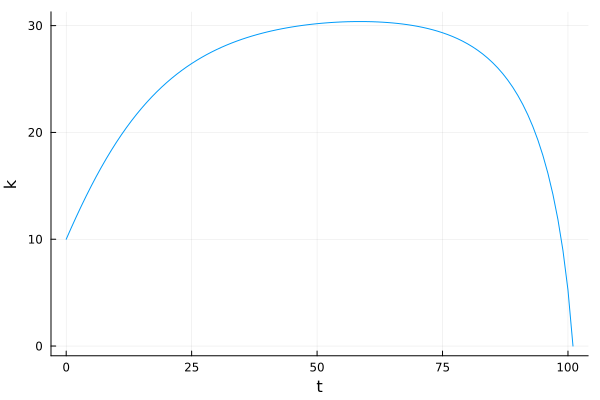

In [20]:
using  LinearAlgebra, SparseArrays, Plots, Parameters, LaTeXStrings

paras = @with_kw (alpha = 0.4, beta = 0.975, delta = 0.025, sigma = 0.5, A = 1.0)
alpha, beta, delta, sigma, A = paras()

a0 = 10.0;

T = 100;   n = 0:1:T+1

k0 = a0.*( 1 .- n./(1+T) )  # 一系列初始值

k_old = k0;

function Phi_k(k,a0, A,alpha,beta,delta,sigma)
    k1_temp = k[1:end-2]
    k2_temp = k[2:end-1]
    k3_temp = k[3:end]
    c1 = A.*k1_temp.^alpha .+ (1-delta).*k1_temp - k2_temp
    c2 = A.*k2_temp.^alpha .+ (1-delta).*k2_temp - k3_temp
    coeff = beta.* ( 1 .+ alpha*A.*k2_temp.^(alpha-1) .- delta )

    F_boundry1 = k[1,1] - a0;  # 边界条件1
    F_boundry2 = k[end,1]  # 边界条件2
    F =  c1.^(-sigma) - coeff .* c2.^(-sigma)  # F(k) = 0

    return [F_boundry1; F; F_boundry2]
end

function jacobian_Phi_k(k, A,alpha,beta,delta,sigma) # 手算 jacobian 导数矩阵
    k1_temp = k[1:end-2]
    k2_temp = k[2:end-1]
    k3_temp = k[3:end]
    c1 = A.*k1_temp.^alpha .+ (1-delta).*k1_temp - k2_temp
    c2 = A.*k2_temp.^alpha .+ (1-delta).*k2_temp - k3_temp
    dc1_dt = alpha*A.*k1_temp.^(alpha-1) .+ 1 .- delta
    dc1_dt1= -1
    dc2_dt1= alpha*A.*k2_temp.^(alpha-1) .+ 1 .- delta
    dc2_dt2= -1
    coeff = beta.* ( 1 .+ alpha*A*k2_temp.^(alpha-1) .- delta )
    dcoeff_t1 = beta*alpha*(alpha-1)*A.*k2_temp.^(alpha-2)

    dG_t = -sigma.*c1.^(-1-sigma).*dc1_dt
    dG_t1= -sigma.*c1.^(-1-sigma).*dc1_dt1 .- dcoeff_t1.*c2.^(-sigma) .- coeff.*(-sigma).*c2.^(-1-sigma).*dc2_dt1
    dG_t2= -coeff.*(-sigma).*c2.^(-1-sigma).*dc2_dt2

    N = length(k)
    d_phi_boundry1 = zeros(1, N); d_phi_boundry1[1,1] = 1   # 边界条件1
    d_phi_boundry2 = zeros(1, N); d_phi_boundry2[1,N] = 1   # 边界条件2

    dGt_tmp = spdiagm( 0=> dG_t, 1=> dG_t1, 2=> dG_t2 )  # 方阵，主对角线记为0，向右记为1,2，向左记为-1,-2
    dGt = dGt_tmp[1:N-2, : ]  # 舍去最后两行

    return [d_phi_boundry1; dGt; d_phi_boundry2] 
end

err = 1
while err > 0.0001
    phi_k = Phi_k(k_old, a0, A,alpha,beta,delta,sigma)
    d_phi_k = jacobian_Phi_k(k_old, A,alpha,beta,delta,sigma)

    k_new = k_old - d_phi_k \ phi_k
    err = norm(k_new - k_old, 2)
    k_old = k_new
end

plot(n, k_old, legend=false, xlabel="t", ylabel="k")

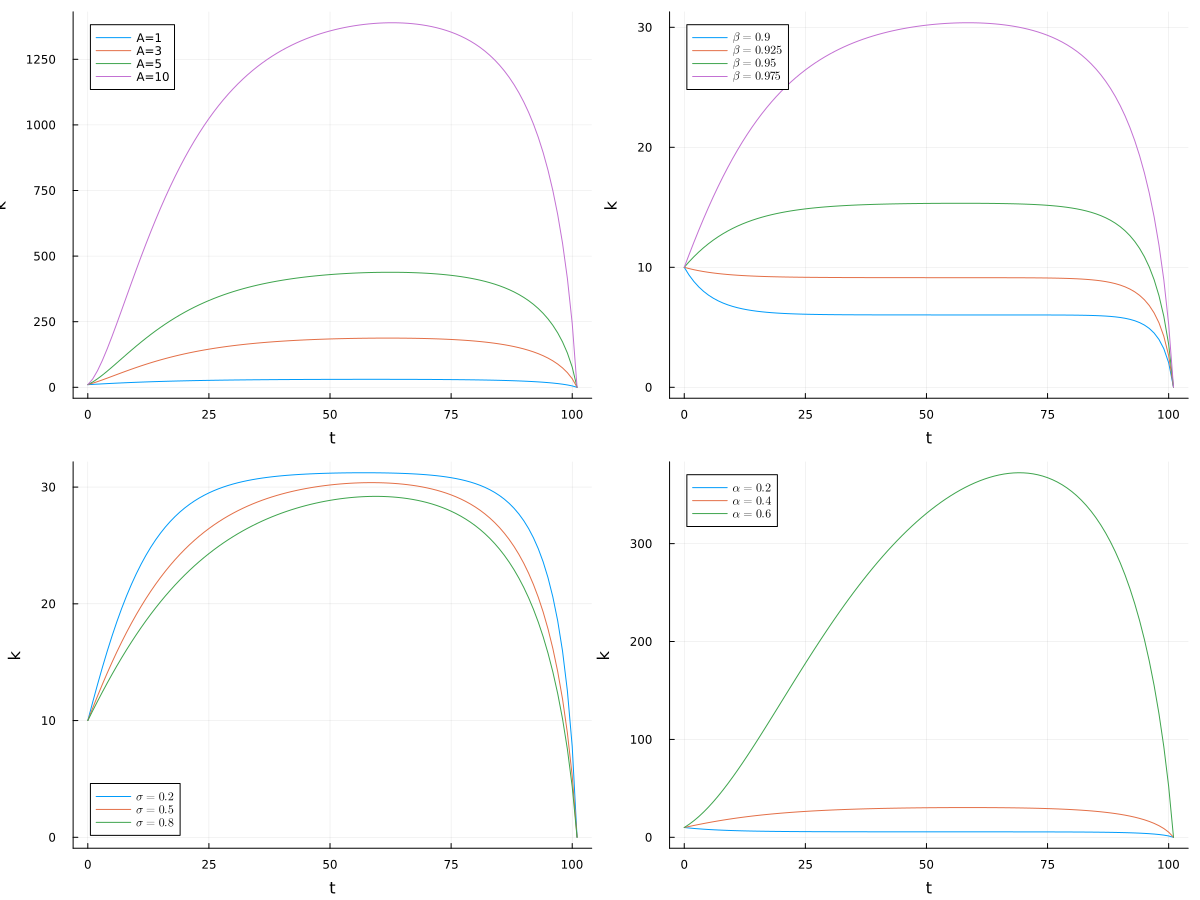

In [21]:
alpha, beta, delta, sigma, A = paras()
A_list = [1,3,5,10]
k_old = k0
k_old_matrix = zeros( length(k_old) , length(A_list))
for (i, A) in enumerate(A_list)
    err = 1
    while err > 0.0001
        phi_k = Phi_k(k_old, a0, A,alpha,beta,delta,sigma)
        d_phi_k = jacobian_Phi_k(k_old, A,alpha,beta,delta,sigma)

        k_new = k_old - d_phi_k \ phi_k
        err = norm(k_new - k_old, 2)
        k_old = k_new
    end
    k_old_matrix[:, i] = k_old
end
p11 = plot(n, k_old_matrix, legend=true, xlabel="t", ylabel="k", label=["A=1"  "A=3"  "A=5"  "A=10"])

alpha, beta, delta, sigma, A = paras()
beta_list = [0.9, 0.925, 0.95, 0.975]
k_old = k0
k_old_matrix = zeros( length(k_old) , length(beta_list))
for (i, beta) in enumerate(beta_list)
    err = 1
    while err > 0.0001
        phi_k = Phi_k(k_old, a0, A,alpha,beta,delta,sigma)
        d_phi_k = jacobian_Phi_k(k_old, A,alpha,beta,delta,sigma)

        k_new = k_old - d_phi_k \ phi_k
        err = norm(k_new - k_old, 2)
        k_old = k_new
    end
    k_old_matrix[:, i] = k_old
end
p12 = plot(n, k_old_matrix, legend=true, xlabel="t", ylabel="k", label=[L"\beta=0.9"  L"\beta=0.925"  L"\beta=0.95"  L"\beta=0.975"])

alpha, beta, delta, sigma, A = paras()
sigma_list = [0.2, 0.5, 0.8]
k_old = k0
k_old_matrix = zeros( length(k_old) , length(sigma_list))
for (i, sigma) in enumerate(sigma_list)
    err = 1
    while err > 0.0001
        phi_k = Phi_k(k_old, a0, A,alpha,beta,delta,sigma)
        d_phi_k = jacobian_Phi_k(k_old, A,alpha,beta,delta,sigma)

        k_new = k_old - d_phi_k \ phi_k
        err = norm(k_new - k_old, 2)
        k_old = k_new
    end
    k_old_matrix[:, i] = k_old
end
p21 = plot(n, k_old_matrix, legend=true, xlabel="t", ylabel="k", label=[L"\sigma=0.2"  L"\sigma=0.5"  L"\sigma=0.8"])

alpha, beta, delta, sigma, A = paras()
alpha_list = [0.2, 0.4, 0.6]
k_old = k0
k_old_matrix = zeros( length(k_old) , length(alpha_list))
for (i, alpha) in enumerate(alpha_list)
    err = 1
    while err > 0.0001
        phi_k = Phi_k(k_old, a0, A,alpha,beta,delta,sigma)
        d_phi_k = jacobian_Phi_k(k_old, A,alpha,beta,delta,sigma)

        k_new = k_old - d_phi_k \ phi_k
        err = norm(k_new - k_old, 2)
        k_old = k_new
    end
    k_old_matrix[:, i] = k_old
end
p22 = plot(n, k_old_matrix, legend=true, xlabel="t", ylabel="k", label=[L"\alpha=0.2"  L"\alpha=0.4"  L"\alpha=0.6"])

plot(p11, p12, p21, p22, layout=(2,2), size=(1200,900))
